In [ ]:
!nvidia-smi

Mon Jan 30 10:07:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
dict1 = {"a": 10, "b": 10, "c": 10}
dict2 = {"a": 10, "b": 10, "c": 10}


TypeError: ignored

In [ ]:
import pandas as pd
from google.colab import drive
import os

drive.mount('/content/drive')
Drive = "/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/"

Mounted at /content/drive


In [ ]:
import cv2
import os
import albumentations as albu

import numpy as np
from PIL import Image

import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import random
import json

import torch
from glob import glob

In [ ]:
config = {
    "train_dir"  :  "/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/output_frame/K-Fold/output_train/",
    "valid_dir"  :  "/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/output_frame/K-Fold/output_valid/",
    "train_gray"  :  "/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/output_frame/output_gray/",
    "train"  :  "/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/output_frame/output_total/",
    "train_dir_scene1"  :  "/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/output_frame/scene_01/",
    "mp4_dir"    :  "/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/train/mp4/",
    "json_dir"   :  "/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/train/json/",
    "output_dir" :  "/content/drive/MyDrive/data_analysis/competition/Signate_Yamaguchi/output/output_img/",
    "output_json_trans" :  "/content/drive/MyDrive/data_analysis/competition/Signate_Yamaguchi/train/json_translated/",
    "output_model" : "/content/drive/MyDrive/data_analysis/competition/Signate_Yamaguchi/output/output_model/model_K-fold/"
}

In [ ]:
colors = {
    '要補修-1.区画線': (1, 0, 0, 1),    # 赤
    '要補修-2.道路標識': (0, 1, 0, 1),  # 緑
    '要補修-3.照明': (0, 0, 1, 1),      # 青
    '補修不要-1.区画線': (1, 1, 0, 1),   # 黄
    '補修不要-2.道路標識': (1, 0, 1, 1), # 紫
    '補修不要-3.照明': (0, 1, 1, 1)     # 水
}

In [ ]:
texts = {
    '要補修-1.区画線': 'need to repair: line',    # 赤
    '要補修-2.道路標識': 'need to repair: sign',  # 緑
    '要補修-3.照明': 'need to repair: light',      # 青
    '補修不要-1.区画線': 'no need to repair: line',   # 黄
    '補修不要-2.道路標識': 'no need to repair: sign', # 紫
    '補修不要-3.照明': 'no need to repair: light'     # 水
}

In [ ]:
# files_check = os.listdir(config["mp4_dir"])
# for f in files_check:
#         cap = cv2.VideoCapture(config["mp4_dir"] + f)
#         fps = cap.get(cv2.CAP_PROP_FPS)
#         frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
#         print('width:', cap.get(cv2.CAP_PROP_FRAME_WIDTH))

In [ ]:
def vis_annotation(image, ann, colors, texts):
    fig, ax = plt.subplots(figsize=(15,15))
    ax.imshow(image)
    for l, bboxes in ann['labels'].items():
        print('{}: {}'.format(l, texts[l]))
        for bbox in bboxes:
            left = min(bbox[0][0], bbox[1][0])
            top = min(bbox[0][1], bbox[1][1])
            width = abs(bbox[1][0] - bbox[0][0])
            height = abs(bbox[1][1] - bbox[0][1])
            rect = patches.Rectangle((left, top), width, height,
                                     linewidth=1,
                                     edgecolor=colors[l],
                                     facecolor='none')
            ax.add_patch(rect)
            bbox_props = dict(boxstyle='square,pad=0', linewidth=1, facecolor=colors[l], edgecolor=colors[l])
            ax.text(left, top, texts[l], ha='left', va='bottom', rotation=0,size=15, bbox=bbox_props)
    plt.show()

In [ ]:
def random_pick(dir_path):
    files_check = os.listdir(dir_path)
    while True:
        f = random.choice(files_check)
        print(f)
        if f.endswith('.json'):
              continue
        break
    print(config["train_dir"] + f)
    frame = np.array(Image.open(dir_path + f))
    print(dir_path + re.sub(".mp4",".json",f))
    with open(dir_path + re.sub(".jpg",".json",f), encoding='utf-8') as f:
        annotation = json.load(f)
    return frame, annotation

In [ ]:
def adjust(img, alpha=1.0, beta=0.0):
    # 積和演算を行う。
    dst = alpha * img + beta
    # [0, 255] でクリップし、uint8 型にする。
    return np.clip(dst, 0, 255).astype(np.uint8)

In [ ]:
def annotate_reverse(annotation):
    annotate_data = annotation["labels"]
    width = 1920
    # print(annotate_data.values())
    for key, value in annotate_data.items():  
        # print("-------------------")
        # print(value)
        # print("-------------------")
        for index, item in enumerate(value):
            for index2, item2 in enumerate(item):
                if index2 % 2 == 0:
                    x1 = width - item2[0]
                else:
                # print(item2)
                    x2 = width - item2[0]
                # print(item2_trans)
                    annotation["labels"][key][index][index2][0] = x1
                    annotation["labels"][key][index][index2 - 1][0] = x2
    reverse_annotate = annotation
    # print(reverse_annotate)
    return reverse_annotate

def image_reverse(image):
    reverse_image = albu.HorizontalFlip(p=1)(image=image)['image'] 
    return reverse_image

In [ ]:
def make_json(split, json_dir, output_dir):
    files_check = os.listdir(json_dir)

    for f in files_check: 
        n = -1
        file_name = f
        annotation_path = os.path.join(json_dir, f)
        with open(annotation_path, encoding='utf-8') as f:
            annotation = json.load(f)
        print(file_name)
        for data in annotation:
            n += 1
            if len(data["labels"]) == 0:
                continue
            if n % split != 0:
                continue
            with open(os.path.join(output_dir, '{}_frame_{:03}.json'.format(re.sub(".json","",file_name) ,data['frame_id'])), 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False, indent=4)

        ################################ 反転した画像も入れる #################################

            reverse_annotation = annotate_reverse(data)
            with open(os.path.join(config["train_dir"], '{}_frame_reverse_{:03}.json'.format(re.sub(".json","",file_name) ,data['frame_id'])), 'w', encoding='utf-8') as f:
                json.dump(reverse_annotation, f, ensure_ascii=False, indent=4)

In [ ]:
def make_frame_jpg_total(output_path, input_path, ext="jpg"):
    
    files_check = os.listdir(input_path)
    print(files_check)

    for f in files_check: 
        print(f)
        if f.endswith('.json'):
            continue
        print(input_path + f)
        cap = cv2.VideoCapture(input_path + f) # 学習用データ

        if not cap.isOpened():
            print("NaN")
            return
        digit = len(str(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))))
        n = 0
        while True:
            trans = re.sub(".mp4","",f)
            ret, frame = cap.read()
            if ret:
                if os.path.isfile(output_path + "{}_frame_{}.json".format(re.sub(".mp4","",f), str(n).zfill(digit))) == True:

                    # frame = adjust(frame, alpha=2.0, beta=25.0)

                    cv2.imwrite(output_path + "{}_frame_{}.{}".format(re.sub(".mp4","",f), str(n).zfill(digit), ext), frame)

                    ################ 反転 ##############################

                    reverse_frame = image_reverse(frame) 
                    cv2.imwrite(output_path + "{}_frame_reverse_{}.{}".format(re.sub(".mp4","",f), str(n).zfill(digit), ext), reverse_frame)

                    #####################################################
                n += 1
            else:
                break

In [ ]:
import shutil

def make_valid(valid, input_path, output_path):
    files_check = os.listdir(input_path)
    json_files = [s for s in files_check if '.json' in s]
    for i in range(int(len(json_files) / valid)):
        data = random.choice(json_files)
        shutil.move(input_path + data, output_path)
        shutil.move(input_path + re.sub("json","jpg", data), output_path)
        json_files.remove(data)

In [ ]:
make_json(1, config["json_dir"], config["train_dir"])
make_frame_jpg_total(config["train_dir"], config["mp4_dir"])

scene_02.json
scene_01.json
scene_00.json
scene_04.json
scene_05.json
scene_03.json
scene_06.json
scene_07.json
scene_08.json
scene_09.json
scene_11.json
scene_10.json
scene_13.json
scene_12.json
scene_16.json
scene_14.json
scene_17.json
scene_15.json
scene_19.json
scene_18.json
scene_20.json
scene_21.json
scene_22.json
['scene_01.mp4', 'scene_00.mp4', 'scene_02.mp4', 'scene_04.mp4', 'scene_03.mp4', 'scene_06.mp4', 'scene_05.mp4', 'scene_07.mp4', 'scene_08.mp4', 'scene_10.mp4', 'scene_09.mp4', 'scene_11.mp4', 'scene_12.mp4', 'scene_13.mp4', 'scene_15.mp4', 'scene_16.mp4', 'scene_14.mp4', 'scene_18.mp4', 'scene_17.mp4', 'scene_19.mp4', 'scene_21.mp4', 'scene_20.mp4', 'scene_22.mp4']
scene_01.mp4
/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/train/mp4/scene_01.mp4
scene_00.mp4
/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/train/mp4/scene_00.mp4
scene_02.mp4
/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/train/mp4/scene_02.m

In [ ]:
make_valid(10, config["train_dir"], config["valid_dir"])

In [ ]:
int(5.4)

5

scene_20_frame_166.json
scene_14_frame_218.jpg
/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/output_frame/K-Fold/output_train/scene_14_frame_218.jpg
/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/output_frame/K-Fold/output_train/scene_14_frame_218.jpg
要補修-1.区画線: need to repair: line
補修不要-3.照明: no need to repair: light


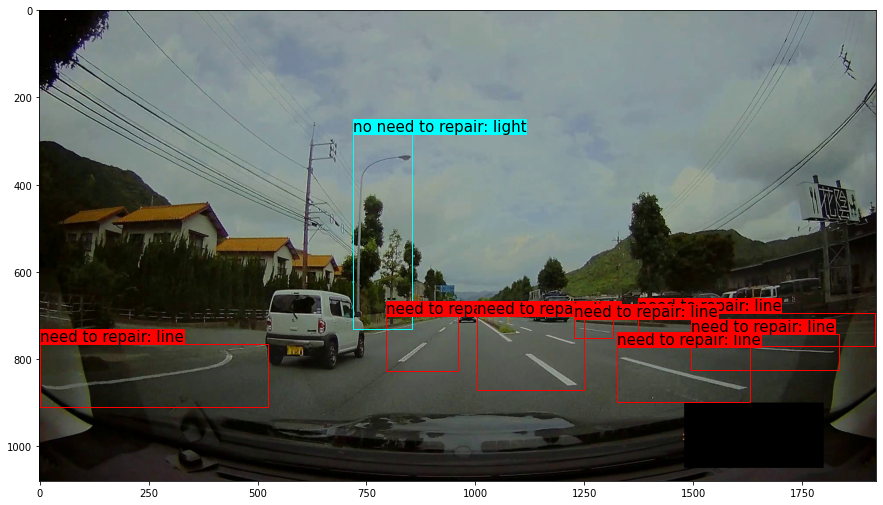

In [ ]:
get_image = random_pick(config["train_dir"])
vis_annotation(get_image[0], get_image[1], colors, texts)

# image = image_reverse(get_image[0])
# annotation = annotate_reverse(get_image[1])

# vis_annotation(image, annotation, colors, texts)

In [ ]:
class FrameDataset(torch.utils.data.Dataset):
    def __init__(self, root, labels, transforms):
        self.root = root
        self.labels = labels
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = sorted(glob(os.path.join(root, '*.jpg')))
        self.annotations = sorted(glob(os.path.join(root, '*.json')))

    def __getitem__(self, idx):
        # load images and annotations
        img_path = self.imgs[idx]
        annotation_path = self.annotations[idx]
        img = Image.open(img_path).convert('RGB')
        with open(annotation_path, encoding='utf-8') as f:
            annotation = json.load(f)

        # get bounding box coordinates and labels
        boxes = []
        labels = []
        for k, v in annotation['labels'].items():
            labels += [self.labels[k]]*len(v)
            for leftright in v: 
                boxes.append(leftright[0]+leftright[1])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
from typing import Dict, List, Optional, Tuple, Union
from torch import nn, Tensor
from torchvision import ops
from torchvision.transforms import functional as F, InterpolationMode, transforms as T


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip(T.RandomHorizontalFlip):
    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        if torch.rand(1) < self.p:
            image = F.hflip(image)
            if target is not None:
                _, _, width = image.shape
                target['boxes'][:, [0, 2]] = width - target['boxes'][:, [2, 0]]
        return image, target


class PILToTensor(nn.Module):
    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        image = F.pil_to_tensor(image)
        return image, target


class ConvertImageDtype(nn.Module):
    def __init__(self, dtype: torch.dtype) -> None:
        super().__init__()
        self.dtype = dtype

    def forward(
        self, image: Tensor, target: Optional[Dict[str, Tensor]] = None
    ) -> Tuple[Tensor, Optional[Dict[str, Tensor]]]:
        image = F.convert_image_dtype(image, self.dtype)
        return image, target


def get_transform(train):
    transforms = []
    transforms.append(PILToTensor())
    transforms.append(ConvertImageDtype(torch.float))
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

In [ ]:
labels = {'要補修-1.区画線':1, '要補修-2.道路標識':2, '要補修-3.照明':3, '補修不要-1.区画線':4, '補修不要-2.道路標識':5, '補修不要-3.照明':6}
frame_dataset_train = FrameDataset(config["train_dir"], labels, get_transform(train=False))
frame_dataset_valid = FrameDataset(config["valid_dir"], labels, get_transform(train=False))

In [ ]:
img, target = frame_dataset_train[0]
img.shape

torch.Size([3, 1080, 1920])

In [ ]:
img, target = frame_dataset_train[0]

print('image:')
print(' ', type(img), img.shape)
print('target:')
for k, v in target.items():
    print('  {}:'.format(k), type(v), v.shape)

image:
  <class 'torch.Tensor'> torch.Size([3, 1080, 1920])
target:
  boxes: <class 'torch.Tensor'> torch.Size([10, 4])
  labels: <class 'torch.Tensor'> torch.Size([10])


In [ ]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=7,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [ ]:
import math
import sys
from tqdm import tqdm

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    size = len(data_loader)
    bar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, (images, targets) in bar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # print(images)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        if (i+1) %print_freq==0:
            loss_each = {k: round(float(v), 3) for k, v in loss_dict.items()}
            print('[{}/{}] Train Loss: {}, {}'.format(i+1, size, round(float(losses),3), loss_each))
        if not math.isfinite(losses):
            print(f"Loss is {losses}, stopping training")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

    loss_each = {k: round(float(v), 3) for k, v in loss_dict.items()}
    print('[{}/{}] Train Final Loss: {}, {}'.format(i+1, size, round(float(losses),3), loss_each))

def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def valid_one_epoch(model, data_loader, device, print_freq):
    size = len(data_loader)
    bar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, (images, targets) in bar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # print(images)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        if (i+1) %print_freq==0:
            loss_each = {k: round(float(v), 3) for k, v in loss_dict.items()}
            print('[{}/{}] Valid Loss: {}, {}'.format(i+1, size, round(float(losses),3), loss_each))
    loss_each = {k: round(float(v), 3) for k, v in loss_dict.items()}
    print('[{}/{}] Valid Final Loss: {}, {}'.format(i+1, size, round(float(losses),3), loss_each))
    return losses

In [ ]:
import torch
import pickle

best_valid_loss = np.inf

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    frame_dataset_train, batch_size=2, shuffle=True,
    collate_fn=collate_fn)

data_loader_valid = torch.utils.data.DataLoader(
    frame_dataset_valid, batch_size=2, shuffle=True,
    collate_fn=collate_fn)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    print('---- Epoch {}: --------------------------------------------------------------------------------'.format(epoch + 1))
    # train for one epoch, printing every 100 iterations
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=100)
    print("----- Valid ------------------------------------------------------------------------------------")
    valid_loss = valid_one_epoch(model, data_loader_valid, device, print_freq=100)
    print("------------------------------------------------------------------------------------------------")
    # update the learning rate
    if valid_loss <= best_valid_loss:
        best_valid_loss = round(float(valid_loss),3)
        with open(config["output_model"] + f"model_SDG_{epoch}.pkl", 'wb') as f:
            pickle.dump(model, f)

    lr_scheduler.step()



---- Epoch 0: --------------------------------------------------------------------------------


  2%|▏         | 100/4722 [00:48<28:13,  2.73it/s]

[100/4722] Train Loss: 0.747, {'loss_classifier': 0.239, 'loss_box_reg': 0.143, 'loss_objectness': 0.281, 'loss_rpn_box_reg': 0.083}


  4%|▍         | 200/4722 [01:26<28:33,  2.64it/s]

[200/4722] Train Loss: 0.526, {'loss_classifier': 0.199, 'loss_box_reg': 0.147, 'loss_objectness': 0.134, 'loss_rpn_box_reg': 0.046}


  6%|▋         | 300/4722 [02:03<27:11,  2.71it/s]

[300/4722] Train Loss: 0.636, {'loss_classifier': 0.24, 'loss_box_reg': 0.26, 'loss_objectness': 0.068, 'loss_rpn_box_reg': 0.068}


  8%|▊         | 400/4722 [02:40<27:00,  2.67it/s]

[400/4722] Train Loss: 0.765, {'loss_classifier': 0.272, 'loss_box_reg': 0.285, 'loss_objectness': 0.121, 'loss_rpn_box_reg': 0.087}


 11%|█         | 500/4722 [03:18<26:33,  2.65it/s]

[500/4722] Train Loss: 0.514, {'loss_classifier': 0.182, 'loss_box_reg': 0.184, 'loss_objectness': 0.091, 'loss_rpn_box_reg': 0.057}


 13%|█▎        | 600/4722 [03:55<25:58,  2.64it/s]

[600/4722] Train Loss: 0.434, {'loss_classifier': 0.136, 'loss_box_reg': 0.182, 'loss_objectness': 0.076, 'loss_rpn_box_reg': 0.039}


 15%|█▍        | 700/4722 [04:33<25:17,  2.65it/s]

[700/4722] Train Loss: 0.553, {'loss_classifier': 0.235, 'loss_box_reg': 0.22, 'loss_objectness': 0.068, 'loss_rpn_box_reg': 0.029}


 17%|█▋        | 800/4722 [05:11<24:40,  2.65it/s]

[800/4722] Train Loss: 0.498, {'loss_classifier': 0.188, 'loss_box_reg': 0.197, 'loss_objectness': 0.06, 'loss_rpn_box_reg': 0.052}


 19%|█▉        | 900/4722 [05:49<24:07,  2.64it/s]

[900/4722] Train Loss: 0.436, {'loss_classifier': 0.155, 'loss_box_reg': 0.195, 'loss_objectness': 0.054, 'loss_rpn_box_reg': 0.032}


 21%|██        | 1000/4722 [06:26<23:20,  2.66it/s]

[1000/4722] Train Loss: 0.609, {'loss_classifier': 0.209, 'loss_box_reg': 0.251, 'loss_objectness': 0.062, 'loss_rpn_box_reg': 0.087}


 23%|██▎       | 1100/4722 [07:04<22:47,  2.65it/s]

[1100/4722] Train Loss: 0.707, {'loss_classifier': 0.271, 'loss_box_reg': 0.22, 'loss_objectness': 0.162, 'loss_rpn_box_reg': 0.054}


 25%|██▌       | 1200/4722 [07:42<22:12,  2.64it/s]

[1200/4722] Train Loss: 0.506, {'loss_classifier': 0.158, 'loss_box_reg': 0.162, 'loss_objectness': 0.097, 'loss_rpn_box_reg': 0.089}


 28%|██▊       | 1300/4722 [08:20<21:33,  2.64it/s]

[1300/4722] Train Loss: 0.505, {'loss_classifier': 0.152, 'loss_box_reg': 0.247, 'loss_objectness': 0.063, 'loss_rpn_box_reg': 0.044}


 30%|██▉       | 1400/4722 [08:58<20:53,  2.65it/s]

[1400/4722] Train Loss: 0.344, {'loss_classifier': 0.115, 'loss_box_reg': 0.181, 'loss_objectness': 0.036, 'loss_rpn_box_reg': 0.013}


 32%|███▏      | 1500/4722 [09:35<20:20,  2.64it/s]

[1500/4722] Train Loss: 0.416, {'loss_classifier': 0.158, 'loss_box_reg': 0.184, 'loss_objectness': 0.043, 'loss_rpn_box_reg': 0.031}


 34%|███▍      | 1600/4722 [10:13<19:34,  2.66it/s]

[1600/4722] Train Loss: 0.267, {'loss_classifier': 0.122, 'loss_box_reg': 0.099, 'loss_objectness': 0.032, 'loss_rpn_box_reg': 0.014}


 36%|███▌      | 1700/4722 [10:51<19:08,  2.63it/s]

[1700/4722] Train Loss: 0.531, {'loss_classifier': 0.167, 'loss_box_reg': 0.204, 'loss_objectness': 0.093, 'loss_rpn_box_reg': 0.067}


 38%|███▊      | 1800/4722 [11:29<18:21,  2.65it/s]

[1800/4722] Train Loss: 0.368, {'loss_classifier': 0.161, 'loss_box_reg': 0.154, 'loss_objectness': 0.038, 'loss_rpn_box_reg': 0.015}


 40%|████      | 1900/4722 [12:06<17:41,  2.66it/s]

[1900/4722] Train Loss: 0.272, {'loss_classifier': 0.12, 'loss_box_reg': 0.108, 'loss_objectness': 0.032, 'loss_rpn_box_reg': 0.012}


 42%|████▏     | 2000/4722 [12:44<17:08,  2.65it/s]

[2000/4722] Train Loss: 0.473, {'loss_classifier': 0.146, 'loss_box_reg': 0.24, 'loss_objectness': 0.031, 'loss_rpn_box_reg': 0.056}


 44%|████▍     | 2100/4722 [13:22<16:29,  2.65it/s]

[2100/4722] Train Loss: 0.365, {'loss_classifier': 0.121, 'loss_box_reg': 0.182, 'loss_objectness': 0.049, 'loss_rpn_box_reg': 0.013}


 47%|████▋     | 2200/4722 [14:00<15:50,  2.65it/s]

[2200/4722] Train Loss: 0.494, {'loss_classifier': 0.169, 'loss_box_reg': 0.206, 'loss_objectness': 0.08, 'loss_rpn_box_reg': 0.039}


 49%|████▊     | 2300/4722 [14:37<15:17,  2.64it/s]

[2300/4722] Train Loss: 0.338, {'loss_classifier': 0.142, 'loss_box_reg': 0.141, 'loss_objectness': 0.033, 'loss_rpn_box_reg': 0.021}


 51%|█████     | 2400/4722 [15:15<14:39,  2.64it/s]

[2400/4722] Train Loss: 0.332, {'loss_classifier': 0.098, 'loss_box_reg': 0.185, 'loss_objectness': 0.028, 'loss_rpn_box_reg': 0.021}


 53%|█████▎    | 2500/4722 [15:53<14:02,  2.64it/s]

[2500/4722] Train Loss: 0.425, {'loss_classifier': 0.161, 'loss_box_reg': 0.169, 'loss_objectness': 0.045, 'loss_rpn_box_reg': 0.049}


 55%|█████▌    | 2600/4722 [16:31<13:23,  2.64it/s]

[2600/4722] Train Loss: 0.532, {'loss_classifier': 0.176, 'loss_box_reg': 0.205, 'loss_objectness': 0.099, 'loss_rpn_box_reg': 0.052}


 57%|█████▋    | 2700/4722 [17:08<12:39,  2.66it/s]

[2700/4722] Train Loss: 0.764, {'loss_classifier': 0.262, 'loss_box_reg': 0.248, 'loss_objectness': 0.187, 'loss_rpn_box_reg': 0.067}


 59%|█████▉    | 2800/4722 [17:46<12:04,  2.65it/s]

[2800/4722] Train Loss: 0.481, {'loss_classifier': 0.193, 'loss_box_reg': 0.247, 'loss_objectness': 0.027, 'loss_rpn_box_reg': 0.014}


 61%|██████▏   | 2900/4722 [18:24<11:29,  2.64it/s]

[2900/4722] Train Loss: 0.448, {'loss_classifier': 0.177, 'loss_box_reg': 0.184, 'loss_objectness': 0.043, 'loss_rpn_box_reg': 0.043}


 64%|██████▎   | 3000/4722 [19:02<10:48,  2.66it/s]

[3000/4722] Train Loss: 0.607, {'loss_classifier': 0.155, 'loss_box_reg': 0.254, 'loss_objectness': 0.052, 'loss_rpn_box_reg': 0.146}


 66%|██████▌   | 3100/4722 [19:39<10:12,  2.65it/s]

[3100/4722] Train Loss: 0.225, {'loss_classifier': 0.069, 'loss_box_reg': 0.12, 'loss_objectness': 0.027, 'loss_rpn_box_reg': 0.01}


 68%|██████▊   | 3200/4722 [20:17<09:34,  2.65it/s]

[3200/4722] Train Loss: 0.42, {'loss_classifier': 0.106, 'loss_box_reg': 0.144, 'loss_objectness': 0.057, 'loss_rpn_box_reg': 0.112}


 70%|██████▉   | 3300/4722 [20:55<08:54,  2.66it/s]

[3300/4722] Train Loss: 0.403, {'loss_classifier': 0.131, 'loss_box_reg': 0.217, 'loss_objectness': 0.037, 'loss_rpn_box_reg': 0.018}


 72%|███████▏  | 3400/4722 [21:32<08:20,  2.64it/s]

[3400/4722] Train Loss: 0.583, {'loss_classifier': 0.178, 'loss_box_reg': 0.202, 'loss_objectness': 0.135, 'loss_rpn_box_reg': 0.067}


 74%|███████▍  | 3500/4722 [22:10<07:40,  2.66it/s]

[3500/4722] Train Loss: 0.353, {'loss_classifier': 0.123, 'loss_box_reg': 0.097, 'loss_objectness': 0.057, 'loss_rpn_box_reg': 0.076}


 76%|███████▌  | 3600/4722 [22:48<06:59,  2.67it/s]

[3600/4722] Train Loss: 0.427, {'loss_classifier': 0.164, 'loss_box_reg': 0.163, 'loss_objectness': 0.063, 'loss_rpn_box_reg': 0.037}


 78%|███████▊  | 3700/4722 [23:26<06:24,  2.66it/s]

[3700/4722] Train Loss: 0.582, {'loss_classifier': 0.225, 'loss_box_reg': 0.265, 'loss_objectness': 0.051, 'loss_rpn_box_reg': 0.041}


 80%|████████  | 3800/4722 [24:03<05:48,  2.65it/s]

[3800/4722] Train Loss: 0.389, {'loss_classifier': 0.15, 'loss_box_reg': 0.171, 'loss_objectness': 0.036, 'loss_rpn_box_reg': 0.032}


 83%|████████▎ | 3900/4722 [24:41<05:11,  2.64it/s]

[3900/4722] Train Loss: 0.306, {'loss_classifier': 0.101, 'loss_box_reg': 0.157, 'loss_objectness': 0.02, 'loss_rpn_box_reg': 0.028}


 85%|████████▍ | 4000/4722 [25:19<04:33,  2.64it/s]

[4000/4722] Train Loss: 0.723, {'loss_classifier': 0.225, 'loss_box_reg': 0.34, 'loss_objectness': 0.058, 'loss_rpn_box_reg': 0.1}


 87%|████████▋ | 4100/4722 [25:56<03:55,  2.64it/s]

[4100/4722] Train Loss: 0.439, {'loss_classifier': 0.146, 'loss_box_reg': 0.255, 'loss_objectness': 0.021, 'loss_rpn_box_reg': 0.016}


 89%|████████▉ | 4200/4722 [26:34<03:15,  2.67it/s]

[4200/4722] Train Loss: 0.459, {'loss_classifier': 0.161, 'loss_box_reg': 0.242, 'loss_objectness': 0.031, 'loss_rpn_box_reg': 0.024}


 91%|█████████ | 4300/4722 [27:12<02:40,  2.63it/s]

[4300/4722] Train Loss: 0.217, {'loss_classifier': 0.067, 'loss_box_reg': 0.102, 'loss_objectness': 0.027, 'loss_rpn_box_reg': 0.021}


 93%|█████████▎| 4400/4722 [27:49<02:01,  2.65it/s]

[4400/4722] Train Loss: 0.254, {'loss_classifier': 0.104, 'loss_box_reg': 0.116, 'loss_objectness': 0.021, 'loss_rpn_box_reg': 0.013}


 95%|█████████▌| 4500/4722 [28:27<01:23,  2.66it/s]

[4500/4722] Train Loss: 0.44, {'loss_classifier': 0.131, 'loss_box_reg': 0.219, 'loss_objectness': 0.029, 'loss_rpn_box_reg': 0.06}


 97%|█████████▋| 4600/4722 [29:05<00:45,  2.65it/s]

[4600/4722] Train Loss: 0.513, {'loss_classifier': 0.172, 'loss_box_reg': 0.24, 'loss_objectness': 0.04, 'loss_rpn_box_reg': 0.061}


100%|█████████▉| 4700/4722 [29:43<00:08,  2.66it/s]

[4700/4722] Train Loss: 0.317, {'loss_classifier': 0.092, 'loss_box_reg': 0.16, 'loss_objectness': 0.023, 'loss_rpn_box_reg': 0.042}


100%|██████████| 4722/4722 [29:51<00:00,  2.64it/s]


[4722/4722] Train Final Loss: 0.184, {'loss_classifier': 0.075, 'loss_box_reg': 0.089, 'loss_objectness': 0.009, 'loss_rpn_box_reg': 0.011}
----- Valid ------------------------------------------------------------------------------------


 19%|█▉        | 101/525 [00:20<01:23,  5.10it/s]

[100/525] Valid Loss: 0.469, {'loss_classifier': 0.141, 'loss_box_reg': 0.21, 'loss_objectness': 0.027, 'loss_rpn_box_reg': 0.091}


 38%|███▊      | 200/525 [00:39<01:05,  4.98it/s]

[200/525] Valid Loss: 0.476, {'loss_classifier': 0.143, 'loss_box_reg': 0.24, 'loss_objectness': 0.058, 'loss_rpn_box_reg': 0.035}


 57%|█████▋    | 301/525 [00:59<00:43,  5.10it/s]

[300/525] Valid Loss: 0.529, {'loss_classifier': 0.18, 'loss_box_reg': 0.248, 'loss_objectness': 0.04, 'loss_rpn_box_reg': 0.061}


 76%|███████▋  | 401/525 [01:19<00:24,  4.99it/s]

[400/525] Valid Loss: 0.397, {'loss_classifier': 0.141, 'loss_box_reg': 0.208, 'loss_objectness': 0.02, 'loss_rpn_box_reg': 0.028}


 95%|█████████▌| 501/525 [01:39<00:04,  5.01it/s]

[500/525] Valid Loss: 0.361, {'loss_classifier': 0.13, 'loss_box_reg': 0.165, 'loss_objectness': 0.043, 'loss_rpn_box_reg': 0.023}


100%|██████████| 525/525 [01:44<00:00,  5.03it/s]


[525/525] Valid Final Loss: 0.342, {'loss_classifier': 0.092, 'loss_box_reg': 0.212, 'loss_objectness': 0.021, 'loss_rpn_box_reg': 0.017}
------------------------------------------------------------------------------------------------
---- Epoch 1: --------------------------------------------------------------------------------


  2%|▏         | 100/4722 [00:38<29:06,  2.65it/s]

[100/4722] Train Loss: 0.38, {'loss_classifier': 0.152, 'loss_box_reg': 0.148, 'loss_objectness': 0.067, 'loss_rpn_box_reg': 0.014}


  4%|▍         | 200/4722 [01:15<28:24,  2.65it/s]

[200/4722] Train Loss: 0.435, {'loss_classifier': 0.148, 'loss_box_reg': 0.217, 'loss_objectness': 0.012, 'loss_rpn_box_reg': 0.059}


  6%|▋         | 300/4722 [01:53<27:46,  2.65it/s]

[300/4722] Train Loss: 0.433, {'loss_classifier': 0.191, 'loss_box_reg': 0.19, 'loss_objectness': 0.034, 'loss_rpn_box_reg': 0.018}


  8%|▊         | 400/4722 [02:31<27:15,  2.64it/s]

[400/4722] Train Loss: 0.384, {'loss_classifier': 0.169, 'loss_box_reg': 0.142, 'loss_objectness': 0.048, 'loss_rpn_box_reg': 0.025}


 11%|█         | 500/4722 [03:08<26:33,  2.65it/s]

[500/4722] Train Loss: 0.281, {'loss_classifier': 0.102, 'loss_box_reg': 0.104, 'loss_objectness': 0.047, 'loss_rpn_box_reg': 0.029}


 13%|█▎        | 600/4722 [03:46<25:52,  2.65it/s]

[600/4722] Train Loss: 0.43, {'loss_classifier': 0.15, 'loss_box_reg': 0.212, 'loss_objectness': 0.038, 'loss_rpn_box_reg': 0.029}


 15%|█▍        | 700/4722 [04:24<25:19,  2.65it/s]

[700/4722] Train Loss: 0.566, {'loss_classifier': 0.16, 'loss_box_reg': 0.288, 'loss_objectness': 0.057, 'loss_rpn_box_reg': 0.061}


 17%|█▋        | 800/4722 [05:02<24:39,  2.65it/s]

[800/4722] Train Loss: 0.286, {'loss_classifier': 0.115, 'loss_box_reg': 0.117, 'loss_objectness': 0.037, 'loss_rpn_box_reg': 0.018}


 19%|█▉        | 900/4722 [05:40<24:02,  2.65it/s]

[900/4722] Train Loss: 0.362, {'loss_classifier': 0.122, 'loss_box_reg': 0.152, 'loss_objectness': 0.051, 'loss_rpn_box_reg': 0.037}


 21%|██        | 1000/4722 [06:18<25:05,  2.47it/s]

[1000/4722] Train Loss: 0.529, {'loss_classifier': 0.205, 'loss_box_reg': 0.25, 'loss_objectness': 0.049, 'loss_rpn_box_reg': 0.025}


 23%|██▎       | 1100/4722 [06:56<22:42,  2.66it/s]

[1100/4722] Train Loss: 0.536, {'loss_classifier': 0.165, 'loss_box_reg': 0.248, 'loss_objectness': 0.043, 'loss_rpn_box_reg': 0.081}


 25%|██▌       | 1200/4722 [07:34<22:08,  2.65it/s]

[1200/4722] Train Loss: 0.272, {'loss_classifier': 0.12, 'loss_box_reg': 0.12, 'loss_objectness': 0.024, 'loss_rpn_box_reg': 0.008}


 28%|██▊       | 1300/4722 [08:11<21:36,  2.64it/s]

[1300/4722] Train Loss: 0.271, {'loss_classifier': 0.085, 'loss_box_reg': 0.134, 'loss_objectness': 0.029, 'loss_rpn_box_reg': 0.022}


 30%|██▉       | 1400/4722 [08:49<20:52,  2.65it/s]

[1400/4722] Train Loss: 0.513, {'loss_classifier': 0.194, 'loss_box_reg': 0.228, 'loss_objectness': 0.048, 'loss_rpn_box_reg': 0.043}


 32%|███▏      | 1500/4722 [09:27<20:17,  2.65it/s]

[1500/4722] Train Loss: 0.406, {'loss_classifier': 0.137, 'loss_box_reg': 0.214, 'loss_objectness': 0.04, 'loss_rpn_box_reg': 0.015}


 34%|███▍      | 1600/4722 [10:04<19:34,  2.66it/s]

[1600/4722] Train Loss: 0.469, {'loss_classifier': 0.15, 'loss_box_reg': 0.205, 'loss_objectness': 0.066, 'loss_rpn_box_reg': 0.048}


 36%|███▌      | 1700/4722 [10:42<19:01,  2.65it/s]

[1700/4722] Train Loss: 0.42, {'loss_classifier': 0.17, 'loss_box_reg': 0.197, 'loss_objectness': 0.038, 'loss_rpn_box_reg': 0.015}


 38%|███▊      | 1800/4722 [11:20<18:19,  2.66it/s]

[1800/4722] Train Loss: 0.432, {'loss_classifier': 0.178, 'loss_box_reg': 0.197, 'loss_objectness': 0.028, 'loss_rpn_box_reg': 0.028}


 40%|████      | 1900/4722 [11:57<17:36,  2.67it/s]

[1900/4722] Train Loss: 0.208, {'loss_classifier': 0.064, 'loss_box_reg': 0.12, 'loss_objectness': 0.014, 'loss_rpn_box_reg': 0.01}


 42%|████▏     | 2000/4722 [12:35<17:07,  2.65it/s]

[2000/4722] Train Loss: 0.255, {'loss_classifier': 0.075, 'loss_box_reg': 0.145, 'loss_objectness': 0.014, 'loss_rpn_box_reg': 0.02}


 44%|████▍     | 2100/4722 [13:13<16:24,  2.66it/s]

[2100/4722] Train Loss: 0.395, {'loss_classifier': 0.132, 'loss_box_reg': 0.188, 'loss_objectness': 0.03, 'loss_rpn_box_reg': 0.045}


 47%|████▋     | 2200/4722 [13:50<15:52,  2.65it/s]

[2200/4722] Train Loss: 0.252, {'loss_classifier': 0.074, 'loss_box_reg': 0.149, 'loss_objectness': 0.022, 'loss_rpn_box_reg': 0.008}


 49%|████▊     | 2300/4722 [14:28<15:09,  2.66it/s]

[2300/4722] Train Loss: 0.567, {'loss_classifier': 0.195, 'loss_box_reg': 0.279, 'loss_objectness': 0.044, 'loss_rpn_box_reg': 0.049}


 51%|█████     | 2400/4722 [15:06<14:37,  2.65it/s]

[2400/4722] Train Loss: 0.806, {'loss_classifier': 0.28, 'loss_box_reg': 0.326, 'loss_objectness': 0.127, 'loss_rpn_box_reg': 0.072}


 53%|█████▎    | 2500/4722 [15:43<13:57,  2.65it/s]

[2500/4722] Train Loss: 0.355, {'loss_classifier': 0.113, 'loss_box_reg': 0.179, 'loss_objectness': 0.036, 'loss_rpn_box_reg': 0.027}


 55%|█████▌    | 2600/4722 [16:21<13:16,  2.66it/s]

[2600/4722] Train Loss: 0.56, {'loss_classifier': 0.177, 'loss_box_reg': 0.266, 'loss_objectness': 0.044, 'loss_rpn_box_reg': 0.073}


 57%|█████▋    | 2700/4722 [16:59<12:42,  2.65it/s]

[2700/4722] Train Loss: 0.273, {'loss_classifier': 0.092, 'loss_box_reg': 0.147, 'loss_objectness': 0.018, 'loss_rpn_box_reg': 0.016}


 59%|█████▉    | 2800/4722 [17:36<12:01,  2.66it/s]

[2800/4722] Train Loss: 0.307, {'loss_classifier': 0.1, 'loss_box_reg': 0.158, 'loss_objectness': 0.031, 'loss_rpn_box_reg': 0.018}


 61%|██████▏   | 2900/4722 [18:14<11:27,  2.65it/s]

[2900/4722] Train Loss: 0.331, {'loss_classifier': 0.112, 'loss_box_reg': 0.172, 'loss_objectness': 0.014, 'loss_rpn_box_reg': 0.032}


 64%|██████▎   | 3000/4722 [18:52<10:46,  2.66it/s]

[3000/4722] Train Loss: 0.252, {'loss_classifier': 0.085, 'loss_box_reg': 0.127, 'loss_objectness': 0.018, 'loss_rpn_box_reg': 0.022}


 66%|██████▌   | 3100/4722 [19:29<10:12,  2.65it/s]

[3100/4722] Train Loss: 0.377, {'loss_classifier': 0.106, 'loss_box_reg': 0.167, 'loss_objectness': 0.065, 'loss_rpn_box_reg': 0.039}


 68%|██████▊   | 3200/4722 [20:07<09:34,  2.65it/s]

[3200/4722] Train Loss: 0.274, {'loss_classifier': 0.119, 'loss_box_reg': 0.129, 'loss_objectness': 0.015, 'loss_rpn_box_reg': 0.012}


 70%|██████▉   | 3300/4722 [20:44<08:57,  2.65it/s]

[3300/4722] Train Loss: 0.376, {'loss_classifier': 0.143, 'loss_box_reg': 0.169, 'loss_objectness': 0.036, 'loss_rpn_box_reg': 0.028}


 72%|███████▏  | 3400/4722 [21:22<08:19,  2.65it/s]

[3400/4722] Train Loss: 0.43, {'loss_classifier': 0.137, 'loss_box_reg': 0.195, 'loss_objectness': 0.064, 'loss_rpn_box_reg': 0.035}


 74%|███████▍  | 3500/4722 [22:00<07:41,  2.65it/s]

[3500/4722] Train Loss: 0.362, {'loss_classifier': 0.127, 'loss_box_reg': 0.183, 'loss_objectness': 0.028, 'loss_rpn_box_reg': 0.024}


 76%|███████▌  | 3600/4722 [22:37<07:03,  2.65it/s]

[3600/4722] Train Loss: 0.442, {'loss_classifier': 0.123, 'loss_box_reg': 0.223, 'loss_objectness': 0.023, 'loss_rpn_box_reg': 0.072}


 78%|███████▊  | 3700/4722 [23:15<06:23,  2.66it/s]

[3700/4722] Train Loss: 0.255, {'loss_classifier': 0.072, 'loss_box_reg': 0.12, 'loss_objectness': 0.04, 'loss_rpn_box_reg': 0.023}


 80%|████████  | 3800/4722 [23:53<05:45,  2.67it/s]

[3800/4722] Train Loss: 0.382, {'loss_classifier': 0.14, 'loss_box_reg': 0.159, 'loss_objectness': 0.048, 'loss_rpn_box_reg': 0.035}


 83%|████████▎ | 3900/4722 [24:30<05:09,  2.66it/s]

[3900/4722] Train Loss: 0.353, {'loss_classifier': 0.159, 'loss_box_reg': 0.152, 'loss_objectness': 0.024, 'loss_rpn_box_reg': 0.018}


 85%|████████▍ | 4000/4722 [25:08<04:32,  2.65it/s]

[4000/4722] Train Loss: 0.349, {'loss_classifier': 0.151, 'loss_box_reg': 0.153, 'loss_objectness': 0.025, 'loss_rpn_box_reg': 0.019}


 87%|████████▋ | 4100/4722 [25:46<03:55,  2.65it/s]

[4100/4722] Train Loss: 0.44, {'loss_classifier': 0.143, 'loss_box_reg': 0.239, 'loss_objectness': 0.025, 'loss_rpn_box_reg': 0.033}


 89%|████████▉ | 4200/4722 [26:24<03:15,  2.67it/s]

[4200/4722] Train Loss: 0.541, {'loss_classifier': 0.2, 'loss_box_reg': 0.226, 'loss_objectness': 0.057, 'loss_rpn_box_reg': 0.059}


 91%|█████████ | 4300/4722 [27:01<02:38,  2.66it/s]

[4300/4722] Train Loss: 0.467, {'loss_classifier': 0.144, 'loss_box_reg': 0.256, 'loss_objectness': 0.034, 'loss_rpn_box_reg': 0.033}


 93%|█████████▎| 4400/4722 [27:39<02:00,  2.66it/s]

[4400/4722] Train Loss: 0.296, {'loss_classifier': 0.106, 'loss_box_reg': 0.124, 'loss_objectness': 0.032, 'loss_rpn_box_reg': 0.033}


 95%|█████████▌| 4500/4722 [28:16<01:23,  2.64it/s]

[4500/4722] Train Loss: 0.361, {'loss_classifier': 0.146, 'loss_box_reg': 0.184, 'loss_objectness': 0.02, 'loss_rpn_box_reg': 0.011}


 97%|█████████▋| 4600/4722 [28:54<00:45,  2.67it/s]

[4600/4722] Train Loss: 0.338, {'loss_classifier': 0.128, 'loss_box_reg': 0.163, 'loss_objectness': 0.024, 'loss_rpn_box_reg': 0.022}


100%|█████████▉| 4700/4722 [29:32<00:08,  2.65it/s]

[4700/4722] Train Loss: 0.222, {'loss_classifier': 0.057, 'loss_box_reg': 0.13, 'loss_objectness': 0.017, 'loss_rpn_box_reg': 0.018}


100%|██████████| 4722/4722 [29:40<00:00,  2.65it/s]


[4722/4722] Train Final Loss: 0.267, {'loss_classifier': 0.099, 'loss_box_reg': 0.131, 'loss_objectness': 0.021, 'loss_rpn_box_reg': 0.015}
----- Valid ------------------------------------------------------------------------------------


 19%|█▉        | 100/525 [00:19<01:23,  5.08it/s]

[100/525] Valid Loss: 0.269, {'loss_classifier': 0.094, 'loss_box_reg': 0.125, 'loss_objectness': 0.03, 'loss_rpn_box_reg': 0.02}


 38%|███▊      | 200/525 [00:39<01:03,  5.08it/s]

[200/525] Valid Loss: 0.291, {'loss_classifier': 0.095, 'loss_box_reg': 0.134, 'loss_objectness': 0.042, 'loss_rpn_box_reg': 0.02}


 57%|█████▋    | 301/525 [00:59<00:43,  5.13it/s]

[300/525] Valid Loss: 0.497, {'loss_classifier': 0.154, 'loss_box_reg': 0.206, 'loss_objectness': 0.059, 'loss_rpn_box_reg': 0.077}


 76%|███████▌  | 400/525 [01:18<00:24,  5.14it/s]

[400/525] Valid Loss: 0.495, {'loss_classifier': 0.155, 'loss_box_reg': 0.197, 'loss_objectness': 0.09, 'loss_rpn_box_reg': 0.053}


 95%|█████████▌| 501/525 [01:39<00:04,  5.12it/s]

[500/525] Valid Loss: 0.319, {'loss_classifier': 0.098, 'loss_box_reg': 0.155, 'loss_objectness': 0.039, 'loss_rpn_box_reg': 0.027}


100%|██████████| 525/525 [01:43<00:00,  5.07it/s]


[525/525] Valid Final Loss: 0.578, {'loss_classifier': 0.164, 'loss_box_reg': 0.31, 'loss_objectness': 0.05, 'loss_rpn_box_reg': 0.054}
------------------------------------------------------------------------------------------------
---- Epoch 2: --------------------------------------------------------------------------------


  2%|▏         | 100/4722 [00:37<29:04,  2.65it/s]

[100/4722] Train Loss: 0.314, {'loss_classifier': 0.112, 'loss_box_reg': 0.158, 'loss_objectness': 0.024, 'loss_rpn_box_reg': 0.02}


  4%|▍         | 200/4722 [01:15<28:17,  2.66it/s]

[200/4722] Train Loss: 0.379, {'loss_classifier': 0.106, 'loss_box_reg': 0.172, 'loss_objectness': 0.032, 'loss_rpn_box_reg': 0.069}


  6%|▋         | 300/4722 [01:53<27:52,  2.64it/s]

[300/4722] Train Loss: 0.185, {'loss_classifier': 0.065, 'loss_box_reg': 0.103, 'loss_objectness': 0.009, 'loss_rpn_box_reg': 0.007}


  8%|▊         | 400/4722 [02:31<27:18,  2.64it/s]

[400/4722] Train Loss: 0.358, {'loss_classifier': 0.103, 'loss_box_reg': 0.211, 'loss_objectness': 0.022, 'loss_rpn_box_reg': 0.022}


 11%|█         | 500/4722 [03:08<26:23,  2.67it/s]

[500/4722] Train Loss: 0.34, {'loss_classifier': 0.102, 'loss_box_reg': 0.154, 'loss_objectness': 0.044, 'loss_rpn_box_reg': 0.039}


 13%|█▎        | 600/4722 [03:46<25:52,  2.66it/s]

[600/4722] Train Loss: 0.584, {'loss_classifier': 0.162, 'loss_box_reg': 0.297, 'loss_objectness': 0.032, 'loss_rpn_box_reg': 0.093}


 15%|█▍        | 700/4722 [04:24<25:20,  2.65it/s]

[700/4722] Train Loss: 0.666, {'loss_classifier': 0.212, 'loss_box_reg': 0.348, 'loss_objectness': 0.071, 'loss_rpn_box_reg': 0.035}


 17%|█▋        | 800/4722 [05:01<24:34,  2.66it/s]

[800/4722] Train Loss: 0.556, {'loss_classifier': 0.146, 'loss_box_reg': 0.3, 'loss_objectness': 0.024, 'loss_rpn_box_reg': 0.085}


 19%|█▉        | 900/4722 [05:39<24:00,  2.65it/s]

[900/4722] Train Loss: 0.21, {'loss_classifier': 0.069, 'loss_box_reg': 0.115, 'loss_objectness': 0.017, 'loss_rpn_box_reg': 0.009}


 21%|██        | 1000/4722 [06:17<23:21,  2.66it/s]

[1000/4722] Train Loss: 0.39, {'loss_classifier': 0.152, 'loss_box_reg': 0.194, 'loss_objectness': 0.024, 'loss_rpn_box_reg': 0.02}


 23%|██▎       | 1100/4722 [06:54<22:50,  2.64it/s]

[1100/4722] Train Loss: 0.358, {'loss_classifier': 0.122, 'loss_box_reg': 0.105, 'loss_objectness': 0.06, 'loss_rpn_box_reg': 0.07}


 25%|██▌       | 1200/4722 [07:32<22:03,  2.66it/s]

[1200/4722] Train Loss: 0.581, {'loss_classifier': 0.211, 'loss_box_reg': 0.247, 'loss_objectness': 0.071, 'loss_rpn_box_reg': 0.051}


 28%|██▊       | 1300/4722 [08:10<21:21,  2.67it/s]

[1300/4722] Train Loss: 0.401, {'loss_classifier': 0.093, 'loss_box_reg': 0.218, 'loss_objectness': 0.017, 'loss_rpn_box_reg': 0.073}


 30%|██▉       | 1400/4722 [08:48<20:52,  2.65it/s]

[1400/4722] Train Loss: 0.325, {'loss_classifier': 0.109, 'loss_box_reg': 0.148, 'loss_objectness': 0.039, 'loss_rpn_box_reg': 0.028}


 32%|███▏      | 1500/4722 [09:26<20:18,  2.65it/s]

[1500/4722] Train Loss: 0.308, {'loss_classifier': 0.119, 'loss_box_reg': 0.146, 'loss_objectness': 0.03, 'loss_rpn_box_reg': 0.013}


 34%|███▍      | 1600/4722 [10:03<19:35,  2.66it/s]

[1600/4722] Train Loss: 0.173, {'loss_classifier': 0.065, 'loss_box_reg': 0.084, 'loss_objectness': 0.015, 'loss_rpn_box_reg': 0.009}


 36%|███▌      | 1700/4722 [10:41<18:58,  2.65it/s]

[1700/4722] Train Loss: 0.38, {'loss_classifier': 0.163, 'loss_box_reg': 0.152, 'loss_objectness': 0.04, 'loss_rpn_box_reg': 0.026}


 38%|███▊      | 1800/4722 [11:19<18:24,  2.64it/s]

[1800/4722] Train Loss: 0.431, {'loss_classifier': 0.151, 'loss_box_reg': 0.184, 'loss_objectness': 0.044, 'loss_rpn_box_reg': 0.052}


 40%|████      | 1900/4722 [11:56<17:47,  2.64it/s]

[1900/4722] Train Loss: 0.445, {'loss_classifier': 0.132, 'loss_box_reg': 0.246, 'loss_objectness': 0.019, 'loss_rpn_box_reg': 0.048}


 42%|████▏     | 2000/4722 [12:34<17:09,  2.64it/s]

[2000/4722] Train Loss: 0.129, {'loss_classifier': 0.045, 'loss_box_reg': 0.067, 'loss_objectness': 0.004, 'loss_rpn_box_reg': 0.014}


 44%|████▍     | 2100/4722 [13:12<16:31,  2.64it/s]

[2100/4722] Train Loss: 0.15, {'loss_classifier': 0.047, 'loss_box_reg': 0.089, 'loss_objectness': 0.006, 'loss_rpn_box_reg': 0.008}


 47%|████▋     | 2200/4722 [13:50<15:55,  2.64it/s]

[2200/4722] Train Loss: 0.538, {'loss_classifier': 0.159, 'loss_box_reg': 0.286, 'loss_objectness': 0.046, 'loss_rpn_box_reg': 0.048}


 49%|████▊     | 2300/4722 [14:27<15:07,  2.67it/s]

[2300/4722] Train Loss: 0.308, {'loss_classifier': 0.11, 'loss_box_reg': 0.143, 'loss_objectness': 0.035, 'loss_rpn_box_reg': 0.02}


 51%|█████     | 2400/4722 [15:05<14:35,  2.65it/s]

[2400/4722] Train Loss: 0.291, {'loss_classifier': 0.087, 'loss_box_reg': 0.123, 'loss_objectness': 0.044, 'loss_rpn_box_reg': 0.037}


 53%|█████▎    | 2500/4722 [15:43<13:56,  2.66it/s]

[2500/4722] Train Loss: 0.282, {'loss_classifier': 0.085, 'loss_box_reg': 0.135, 'loss_objectness': 0.043, 'loss_rpn_box_reg': 0.019}


 55%|█████▌    | 2600/4722 [16:20<13:15,  2.67it/s]

[2600/4722] Train Loss: 0.348, {'loss_classifier': 0.115, 'loss_box_reg': 0.167, 'loss_objectness': 0.034, 'loss_rpn_box_reg': 0.032}


 57%|█████▋    | 2700/4722 [16:58<12:37,  2.67it/s]

[2700/4722] Train Loss: 0.628, {'loss_classifier': 0.192, 'loss_box_reg': 0.243, 'loss_objectness': 0.069, 'loss_rpn_box_reg': 0.124}


 59%|█████▉    | 2800/4722 [17:36<12:01,  2.66it/s]

[2800/4722] Train Loss: 0.483, {'loss_classifier': 0.204, 'loss_box_reg': 0.197, 'loss_objectness': 0.042, 'loss_rpn_box_reg': 0.04}


 61%|██████▏   | 2900/4722 [18:13<11:27,  2.65it/s]

[2900/4722] Train Loss: 0.345, {'loss_classifier': 0.102, 'loss_box_reg': 0.185, 'loss_objectness': 0.043, 'loss_rpn_box_reg': 0.015}


 64%|██████▎   | 3000/4722 [18:51<10:44,  2.67it/s]

[3000/4722] Train Loss: 0.456, {'loss_classifier': 0.158, 'loss_box_reg': 0.254, 'loss_objectness': 0.02, 'loss_rpn_box_reg': 0.024}


 66%|██████▌   | 3100/4722 [19:29<10:12,  2.65it/s]

[3100/4722] Train Loss: 0.546, {'loss_classifier': 0.169, 'loss_box_reg': 0.286, 'loss_objectness': 0.025, 'loss_rpn_box_reg': 0.066}


 68%|██████▊   | 3200/4722 [20:07<09:29,  2.67it/s]

[3200/4722] Train Loss: 0.36, {'loss_classifier': 0.132, 'loss_box_reg': 0.144, 'loss_objectness': 0.046, 'loss_rpn_box_reg': 0.038}


 70%|██████▉   | 3300/4722 [20:45<08:57,  2.64it/s]

[3300/4722] Train Loss: 0.211, {'loss_classifier': 0.075, 'loss_box_reg': 0.107, 'loss_objectness': 0.021, 'loss_rpn_box_reg': 0.009}


 72%|███████▏  | 3400/4722 [21:22<08:18,  2.65it/s]

[3400/4722] Train Loss: 0.415, {'loss_classifier': 0.132, 'loss_box_reg': 0.228, 'loss_objectness': 0.031, 'loss_rpn_box_reg': 0.023}


 74%|███████▍  | 3500/4722 [22:00<07:42,  2.64it/s]

[3500/4722] Train Loss: 0.362, {'loss_classifier': 0.151, 'loss_box_reg': 0.173, 'loss_objectness': 0.025, 'loss_rpn_box_reg': 0.012}


 76%|███████▌  | 3600/4722 [22:38<07:04,  2.64it/s]

[3600/4722] Train Loss: 0.534, {'loss_classifier': 0.18, 'loss_box_reg': 0.237, 'loss_objectness': 0.052, 'loss_rpn_box_reg': 0.066}


 78%|███████▊  | 3700/4722 [23:15<06:25,  2.65it/s]

[3700/4722] Train Loss: 0.41, {'loss_classifier': 0.132, 'loss_box_reg': 0.226, 'loss_objectness': 0.028, 'loss_rpn_box_reg': 0.024}


 80%|████████  | 3800/4722 [23:53<05:48,  2.64it/s]

[3800/4722] Train Loss: 0.331, {'loss_classifier': 0.125, 'loss_box_reg': 0.168, 'loss_objectness': 0.018, 'loss_rpn_box_reg': 0.019}


 83%|████████▎ | 3900/4722 [24:31<05:09,  2.65it/s]

[3900/4722] Train Loss: 0.528, {'loss_classifier': 0.186, 'loss_box_reg': 0.269, 'loss_objectness': 0.046, 'loss_rpn_box_reg': 0.027}


 85%|████████▍ | 4000/4722 [25:09<04:31,  2.66it/s]

[4000/4722] Train Loss: 0.321, {'loss_classifier': 0.121, 'loss_box_reg': 0.135, 'loss_objectness': 0.032, 'loss_rpn_box_reg': 0.033}


 87%|████████▋ | 4100/4722 [25:46<03:53,  2.66it/s]

[4100/4722] Train Loss: 0.453, {'loss_classifier': 0.122, 'loss_box_reg': 0.221, 'loss_objectness': 0.047, 'loss_rpn_box_reg': 0.063}


 89%|████████▉ | 4200/4722 [26:24<03:17,  2.64it/s]

[4200/4722] Train Loss: 0.414, {'loss_classifier': 0.139, 'loss_box_reg': 0.211, 'loss_objectness': 0.037, 'loss_rpn_box_reg': 0.026}


 91%|█████████ | 4300/4722 [27:02<02:39,  2.65it/s]

[4300/4722] Train Loss: 0.299, {'loss_classifier': 0.114, 'loss_box_reg': 0.131, 'loss_objectness': 0.028, 'loss_rpn_box_reg': 0.027}


 93%|█████████▎| 4400/4722 [27:39<02:00,  2.66it/s]

[4400/4722] Train Loss: 0.327, {'loss_classifier': 0.098, 'loss_box_reg': 0.183, 'loss_objectness': 0.023, 'loss_rpn_box_reg': 0.023}


 95%|█████████▌| 4500/4722 [28:17<01:24,  2.64it/s]

[4500/4722] Train Loss: 0.335, {'loss_classifier': 0.122, 'loss_box_reg': 0.163, 'loss_objectness': 0.03, 'loss_rpn_box_reg': 0.021}


 97%|█████████▋| 4600/4722 [28:55<00:45,  2.65it/s]

[4600/4722] Train Loss: 0.446, {'loss_classifier': 0.134, 'loss_box_reg': 0.243, 'loss_objectness': 0.036, 'loss_rpn_box_reg': 0.032}


100%|█████████▉| 4700/4722 [29:33<00:08,  2.65it/s]

[4700/4722] Train Loss: 0.229, {'loss_classifier': 0.067, 'loss_box_reg': 0.13, 'loss_objectness': 0.018, 'loss_rpn_box_reg': 0.014}


100%|██████████| 4722/4722 [29:41<00:00,  2.65it/s]


[4722/4722] Train Final Loss: 0.502, {'loss_classifier': 0.202, 'loss_box_reg': 0.252, 'loss_objectness': 0.021, 'loss_rpn_box_reg': 0.027}
----- Valid ------------------------------------------------------------------------------------


 19%|█▉        | 100/525 [00:19<01:24,  5.02it/s]

[100/525] Valid Loss: 0.423, {'loss_classifier': 0.144, 'loss_box_reg': 0.174, 'loss_objectness': 0.055, 'loss_rpn_box_reg': 0.05}


 38%|███▊      | 201/525 [00:39<01:03,  5.11it/s]

[200/525] Valid Loss: 0.426, {'loss_classifier': 0.162, 'loss_box_reg': 0.211, 'loss_objectness': 0.016, 'loss_rpn_box_reg': 0.037}


 57%|█████▋    | 301/525 [00:59<00:44,  5.08it/s]

[300/525] Valid Loss: 0.453, {'loss_classifier': 0.161, 'loss_box_reg': 0.202, 'loss_objectness': 0.052, 'loss_rpn_box_reg': 0.039}


 76%|███████▋  | 401/525 [01:19<00:24,  5.09it/s]

[400/525] Valid Loss: 0.511, {'loss_classifier': 0.158, 'loss_box_reg': 0.185, 'loss_objectness': 0.066, 'loss_rpn_box_reg': 0.102}


 95%|█████████▌| 500/525 [01:39<00:05,  4.93it/s]

[500/525] Valid Loss: 0.391, {'loss_classifier': 0.135, 'loss_box_reg': 0.178, 'loss_objectness': 0.043, 'loss_rpn_box_reg': 0.035}


100%|██████████| 525/525 [01:44<00:00,  5.05it/s]


[525/525] Valid Final Loss: 0.368, {'loss_classifier': 0.134, 'loss_box_reg': 0.149, 'loss_objectness': 0.048, 'loss_rpn_box_reg': 0.037}
------------------------------------------------------------------------------------------------
---- Epoch 3: --------------------------------------------------------------------------------


  2%|▏         | 100/4722 [00:37<29:13,  2.64it/s]

[100/4722] Train Loss: 0.228, {'loss_classifier': 0.07, 'loss_box_reg': 0.114, 'loss_objectness': 0.013, 'loss_rpn_box_reg': 0.031}


  4%|▍         | 200/4722 [01:15<28:28,  2.65it/s]

[200/4722] Train Loss: 0.568, {'loss_classifier': 0.164, 'loss_box_reg': 0.268, 'loss_objectness': 0.06, 'loss_rpn_box_reg': 0.076}


  6%|▋         | 300/4722 [01:53<27:49,  2.65it/s]

[300/4722] Train Loss: 0.391, {'loss_classifier': 0.107, 'loss_box_reg': 0.213, 'loss_objectness': 0.028, 'loss_rpn_box_reg': 0.043}


  8%|▊         | 400/4722 [02:31<27:13,  2.65it/s]

[400/4722] Train Loss: 0.163, {'loss_classifier': 0.053, 'loss_box_reg': 0.081, 'loss_objectness': 0.018, 'loss_rpn_box_reg': 0.011}


 11%|█         | 500/4722 [03:08<26:22,  2.67it/s]

[500/4722] Train Loss: 0.35, {'loss_classifier': 0.075, 'loss_box_reg': 0.178, 'loss_objectness': 0.064, 'loss_rpn_box_reg': 0.034}


 13%|█▎        | 600/4722 [03:46<25:43,  2.67it/s]

[600/4722] Train Loss: 0.102, {'loss_classifier': 0.038, 'loss_box_reg': 0.058, 'loss_objectness': 0.004, 'loss_rpn_box_reg': 0.002}


 15%|█▍        | 700/4722 [04:24<25:22,  2.64it/s]

[700/4722] Train Loss: 0.371, {'loss_classifier': 0.113, 'loss_box_reg': 0.215, 'loss_objectness': 0.019, 'loss_rpn_box_reg': 0.023}


 17%|█▋        | 800/4722 [05:02<24:40,  2.65it/s]

[800/4722] Train Loss: 0.205, {'loss_classifier': 0.062, 'loss_box_reg': 0.123, 'loss_objectness': 0.008, 'loss_rpn_box_reg': 0.012}


 19%|█▉        | 900/4722 [05:40<24:00,  2.65it/s]

[900/4722] Train Loss: 0.21, {'loss_classifier': 0.08, 'loss_box_reg': 0.118, 'loss_objectness': 0.005, 'loss_rpn_box_reg': 0.006}


 21%|██        | 1000/4722 [06:17<23:27,  2.64it/s]

[1000/4722] Train Loss: 0.247, {'loss_classifier': 0.071, 'loss_box_reg': 0.144, 'loss_objectness': 0.013, 'loss_rpn_box_reg': 0.019}


 23%|██▎       | 1100/4722 [06:55<22:51,  2.64it/s]

[1100/4722] Train Loss: 0.292, {'loss_classifier': 0.098, 'loss_box_reg': 0.11, 'loss_objectness': 0.031, 'loss_rpn_box_reg': 0.053}


 25%|██▌       | 1200/4722 [07:33<22:15,  2.64it/s]

[1200/4722] Train Loss: 0.287, {'loss_classifier': 0.071, 'loss_box_reg': 0.182, 'loss_objectness': 0.019, 'loss_rpn_box_reg': 0.015}


 28%|██▊       | 1300/4722 [08:11<21:35,  2.64it/s]

[1300/4722] Train Loss: 0.183, {'loss_classifier': 0.068, 'loss_box_reg': 0.091, 'loss_objectness': 0.017, 'loss_rpn_box_reg': 0.007}


 30%|██▉       | 1400/4722 [08:48<20:50,  2.66it/s]

[1400/4722] Train Loss: 0.437, {'loss_classifier': 0.107, 'loss_box_reg': 0.236, 'loss_objectness': 0.021, 'loss_rpn_box_reg': 0.073}


 32%|███▏      | 1500/4722 [09:26<20:20,  2.64it/s]

[1500/4722] Train Loss: 0.361, {'loss_classifier': 0.14, 'loss_box_reg': 0.179, 'loss_objectness': 0.023, 'loss_rpn_box_reg': 0.019}


 34%|███▍      | 1600/4722 [10:04<19:33,  2.66it/s]

[1600/4722] Train Loss: 0.51, {'loss_classifier': 0.178, 'loss_box_reg': 0.233, 'loss_objectness': 0.056, 'loss_rpn_box_reg': 0.043}


 36%|███▌      | 1700/4722 [10:42<19:02,  2.65it/s]

[1700/4722] Train Loss: 0.258, {'loss_classifier': 0.088, 'loss_box_reg': 0.148, 'loss_objectness': 0.012, 'loss_rpn_box_reg': 0.009}


 38%|███▊      | 1800/4722 [11:20<18:16,  2.66it/s]

[1800/4722] Train Loss: 0.115, {'loss_classifier': 0.04, 'loss_box_reg': 0.06, 'loss_objectness': 0.01, 'loss_rpn_box_reg': 0.006}


 40%|████      | 1900/4722 [11:57<17:40,  2.66it/s]

[1900/4722] Train Loss: 0.39, {'loss_classifier': 0.152, 'loss_box_reg': 0.169, 'loss_objectness': 0.041, 'loss_rpn_box_reg': 0.027}


 42%|████▏     | 2000/4722 [12:35<17:11,  2.64it/s]

[2000/4722] Train Loss: 0.194, {'loss_classifier': 0.069, 'loss_box_reg': 0.1, 'loss_objectness': 0.019, 'loss_rpn_box_reg': 0.007}


 44%|████▍     | 2100/4722 [13:13<16:33,  2.64it/s]

[2100/4722] Train Loss: 0.209, {'loss_classifier': 0.074, 'loss_box_reg': 0.117, 'loss_objectness': 0.007, 'loss_rpn_box_reg': 0.011}


 47%|████▋     | 2200/4722 [13:51<15:53,  2.65it/s]

[2200/4722] Train Loss: 0.371, {'loss_classifier': 0.106, 'loss_box_reg': 0.195, 'loss_objectness': 0.037, 'loss_rpn_box_reg': 0.032}


 49%|████▊     | 2300/4722 [14:29<15:15,  2.65it/s]

[2300/4722] Train Loss: 0.191, {'loss_classifier': 0.062, 'loss_box_reg': 0.117, 'loss_objectness': 0.008, 'loss_rpn_box_reg': 0.005}


 51%|█████     | 2400/4722 [15:06<14:35,  2.65it/s]

[2400/4722] Train Loss: 0.294, {'loss_classifier': 0.077, 'loss_box_reg': 0.17, 'loss_objectness': 0.022, 'loss_rpn_box_reg': 0.024}


 53%|█████▎    | 2500/4722 [15:44<14:01,  2.64it/s]

[2500/4722] Train Loss: 0.194, {'loss_classifier': 0.073, 'loss_box_reg': 0.104, 'loss_objectness': 0.011, 'loss_rpn_box_reg': 0.005}


 55%|█████▌    | 2600/4722 [16:22<13:21,  2.65it/s]

[2600/4722] Train Loss: 0.25, {'loss_classifier': 0.084, 'loss_box_reg': 0.115, 'loss_objectness': 0.038, 'loss_rpn_box_reg': 0.013}


 57%|█████▋    | 2700/4722 [17:00<12:47,  2.64it/s]

[2700/4722] Train Loss: 0.172, {'loss_classifier': 0.062, 'loss_box_reg': 0.095, 'loss_objectness': 0.006, 'loss_rpn_box_reg': 0.008}


 59%|█████▉    | 2800/4722 [17:38<12:08,  2.64it/s]

[2800/4722] Train Loss: 0.222, {'loss_classifier': 0.044, 'loss_box_reg': 0.129, 'loss_objectness': 0.018, 'loss_rpn_box_reg': 0.031}


 61%|██████▏   | 2900/4722 [18:16<11:27,  2.65it/s]

[2900/4722] Train Loss: 0.147, {'loss_classifier': 0.045, 'loss_box_reg': 0.081, 'loss_objectness': 0.01, 'loss_rpn_box_reg': 0.01}


 64%|██████▎   | 3000/4722 [18:53<10:52,  2.64it/s]

[3000/4722] Train Loss: 0.479, {'loss_classifier': 0.124, 'loss_box_reg': 0.205, 'loss_objectness': 0.051, 'loss_rpn_box_reg': 0.099}


 66%|██████▌   | 3100/4722 [19:31<10:14,  2.64it/s]

[3100/4722] Train Loss: 0.41, {'loss_classifier': 0.113, 'loss_box_reg': 0.222, 'loss_objectness': 0.022, 'loss_rpn_box_reg': 0.052}


 68%|██████▊   | 3200/4722 [20:09<09:37,  2.63it/s]

[3200/4722] Train Loss: 0.521, {'loss_classifier': 0.161, 'loss_box_reg': 0.285, 'loss_objectness': 0.025, 'loss_rpn_box_reg': 0.05}


 70%|██████▉   | 3300/4722 [20:47<08:56,  2.65it/s]

[3300/4722] Train Loss: 0.45, {'loss_classifier': 0.144, 'loss_box_reg': 0.263, 'loss_objectness': 0.019, 'loss_rpn_box_reg': 0.024}


 72%|███████▏  | 3400/4722 [21:25<08:17,  2.66it/s]

[3400/4722] Train Loss: 0.369, {'loss_classifier': 0.114, 'loss_box_reg': 0.209, 'loss_objectness': 0.024, 'loss_rpn_box_reg': 0.023}


 74%|███████▍  | 3500/4722 [22:02<07:43,  2.64it/s]

[3500/4722] Train Loss: 0.386, {'loss_classifier': 0.109, 'loss_box_reg': 0.204, 'loss_objectness': 0.037, 'loss_rpn_box_reg': 0.035}


 76%|███████▌  | 3600/4722 [22:40<07:04,  2.65it/s]

[3600/4722] Train Loss: 0.238, {'loss_classifier': 0.092, 'loss_box_reg': 0.134, 'loss_objectness': 0.007, 'loss_rpn_box_reg': 0.005}


 78%|███████▊  | 3700/4722 [23:18<06:26,  2.64it/s]

[3700/4722] Train Loss: 0.279, {'loss_classifier': 0.082, 'loss_box_reg': 0.167, 'loss_objectness': 0.022, 'loss_rpn_box_reg': 0.008}


 80%|████████  | 3800/4722 [23:56<05:49,  2.64it/s]

[3800/4722] Train Loss: 0.18, {'loss_classifier': 0.068, 'loss_box_reg': 0.102, 'loss_objectness': 0.005, 'loss_rpn_box_reg': 0.004}


 83%|████████▎ | 3900/4722 [24:34<05:11,  2.64it/s]

[3900/4722] Train Loss: 0.188, {'loss_classifier': 0.066, 'loss_box_reg': 0.108, 'loss_objectness': 0.005, 'loss_rpn_box_reg': 0.008}


 85%|████████▍ | 4000/4722 [25:12<04:32,  2.65it/s]

[4000/4722] Train Loss: 0.337, {'loss_classifier': 0.11, 'loss_box_reg': 0.178, 'loss_objectness': 0.015, 'loss_rpn_box_reg': 0.034}


 87%|████████▋ | 4100/4722 [25:50<03:55,  2.64it/s]

[4100/4722] Train Loss: 0.327, {'loss_classifier': 0.123, 'loss_box_reg': 0.159, 'loss_objectness': 0.016, 'loss_rpn_box_reg': 0.029}


 89%|████████▉ | 4200/4722 [26:27<03:17,  2.64it/s]

[4200/4722] Train Loss: 0.113, {'loss_classifier': 0.031, 'loss_box_reg': 0.074, 'loss_objectness': 0.002, 'loss_rpn_box_reg': 0.007}


 91%|█████████ | 4300/4722 [27:05<02:39,  2.65it/s]

[4300/4722] Train Loss: 0.476, {'loss_classifier': 0.147, 'loss_box_reg': 0.276, 'loss_objectness': 0.032, 'loss_rpn_box_reg': 0.021}


 93%|█████████▎| 4400/4722 [27:43<02:01,  2.64it/s]

[4400/4722] Train Loss: 0.771, {'loss_classifier': 0.182, 'loss_box_reg': 0.281, 'loss_objectness': 0.116, 'loss_rpn_box_reg': 0.193}


 95%|█████████▌| 4500/4722 [28:21<01:23,  2.66it/s]

[4500/4722] Train Loss: 0.377, {'loss_classifier': 0.152, 'loss_box_reg': 0.196, 'loss_objectness': 0.012, 'loss_rpn_box_reg': 0.016}


 97%|█████████▋| 4600/4722 [28:59<00:46,  2.65it/s]

[4600/4722] Train Loss: 0.207, {'loss_classifier': 0.075, 'loss_box_reg': 0.099, 'loss_objectness': 0.015, 'loss_rpn_box_reg': 0.017}


100%|█████████▉| 4700/4722 [29:36<00:08,  2.64it/s]

[4700/4722] Train Loss: 0.293, {'loss_classifier': 0.084, 'loss_box_reg': 0.119, 'loss_objectness': 0.023, 'loss_rpn_box_reg': 0.067}


100%|██████████| 4722/4722 [29:45<00:00,  2.65it/s]


[4722/4722] Train Final Loss: 0.33, {'loss_classifier': 0.077, 'loss_box_reg': 0.207, 'loss_objectness': 0.005, 'loss_rpn_box_reg': 0.04}
----- Valid ------------------------------------------------------------------------------------


 19%|█▉        | 101/525 [00:19<01:23,  5.06it/s]

[100/525] Valid Loss: 0.823, {'loss_classifier': 0.155, 'loss_box_reg': 0.258, 'loss_objectness': 0.162, 'loss_rpn_box_reg': 0.249}


 38%|███▊      | 201/525 [00:39<01:02,  5.15it/s]

[200/525] Valid Loss: 0.42, {'loss_classifier': 0.134, 'loss_box_reg': 0.238, 'loss_objectness': 0.017, 'loss_rpn_box_reg': 0.03}


 57%|█████▋    | 301/525 [00:59<00:43,  5.10it/s]

[300/525] Valid Loss: 0.319, {'loss_classifier': 0.089, 'loss_box_reg': 0.196, 'loss_objectness': 0.015, 'loss_rpn_box_reg': 0.019}


 76%|███████▋  | 401/525 [01:19<00:24,  5.10it/s]

[400/525] Valid Loss: 0.451, {'loss_classifier': 0.198, 'loss_box_reg': 0.197, 'loss_objectness': 0.024, 'loss_rpn_box_reg': 0.032}


 95%|█████████▌| 501/525 [01:38<00:04,  5.02it/s]

[500/525] Valid Loss: 0.163, {'loss_classifier': 0.046, 'loss_box_reg': 0.102, 'loss_objectness': 0.007, 'loss_rpn_box_reg': 0.007}


100%|██████████| 525/525 [01:43<00:00,  5.08it/s]


[525/525] Valid Final Loss: 0.139, {'loss_classifier': 0.046, 'loss_box_reg': 0.087, 'loss_objectness': 0.002, 'loss_rpn_box_reg': 0.004}
------------------------------------------------------------------------------------------------
---- Epoch 4: --------------------------------------------------------------------------------


  2%|▏         | 100/4722 [00:37<29:02,  2.65it/s]

[100/4722] Train Loss: 0.22, {'loss_classifier': 0.055, 'loss_box_reg': 0.145, 'loss_objectness': 0.007, 'loss_rpn_box_reg': 0.012}


  4%|▍         | 200/4722 [01:15<28:25,  2.65it/s]

[200/4722] Train Loss: 0.152, {'loss_classifier': 0.049, 'loss_box_reg': 0.075, 'loss_objectness': 0.017, 'loss_rpn_box_reg': 0.012}


  6%|▋         | 300/4722 [01:53<27:55,  2.64it/s]

[300/4722] Train Loss: 0.241, {'loss_classifier': 0.08, 'loss_box_reg': 0.128, 'loss_objectness': 0.018, 'loss_rpn_box_reg': 0.015}


  8%|▊         | 400/4722 [02:31<27:12,  2.65it/s]

[400/4722] Train Loss: 0.323, {'loss_classifier': 0.134, 'loss_box_reg': 0.152, 'loss_objectness': 0.021, 'loss_rpn_box_reg': 0.016}


 11%|█         | 500/4722 [03:09<26:43,  2.63it/s]

[500/4722] Train Loss: 0.151, {'loss_classifier': 0.035, 'loss_box_reg': 0.086, 'loss_objectness': 0.018, 'loss_rpn_box_reg': 0.013}


 13%|█▎        | 600/4722 [03:46<25:58,  2.64it/s]

[600/4722] Train Loss: 0.472, {'loss_classifier': 0.133, 'loss_box_reg': 0.237, 'loss_objectness': 0.038, 'loss_rpn_box_reg': 0.063}


 15%|█▍        | 700/4722 [04:24<25:19,  2.65it/s]

[700/4722] Train Loss: 0.201, {'loss_classifier': 0.052, 'loss_box_reg': 0.124, 'loss_objectness': 0.015, 'loss_rpn_box_reg': 0.011}


 17%|█▋        | 800/4722 [05:02<24:46,  2.64it/s]

[800/4722] Train Loss: 0.18, {'loss_classifier': 0.076, 'loss_box_reg': 0.089, 'loss_objectness': 0.006, 'loss_rpn_box_reg': 0.01}


 19%|█▉        | 900/4722 [05:40<24:03,  2.65it/s]

[900/4722] Train Loss: 0.331, {'loss_classifier': 0.093, 'loss_box_reg': 0.197, 'loss_objectness': 0.016, 'loss_rpn_box_reg': 0.025}


 21%|██        | 1000/4722 [06:18<23:22,  2.65it/s]

[1000/4722] Train Loss: 0.368, {'loss_classifier': 0.104, 'loss_box_reg': 0.176, 'loss_objectness': 0.04, 'loss_rpn_box_reg': 0.048}


 23%|██▎       | 1100/4722 [06:55<22:45,  2.65it/s]

[1100/4722] Train Loss: 0.265, {'loss_classifier': 0.086, 'loss_box_reg': 0.142, 'loss_objectness': 0.022, 'loss_rpn_box_reg': 0.015}


 25%|██▌       | 1200/4722 [07:33<22:11,  2.65it/s]

[1200/4722] Train Loss: 0.305, {'loss_classifier': 0.111, 'loss_box_reg': 0.156, 'loss_objectness': 0.021, 'loss_rpn_box_reg': 0.017}


 28%|██▊       | 1300/4722 [08:11<21:30,  2.65it/s]

[1300/4722] Train Loss: 0.168, {'loss_classifier': 0.06, 'loss_box_reg': 0.082, 'loss_objectness': 0.018, 'loss_rpn_box_reg': 0.008}


 30%|██▉       | 1400/4722 [08:49<20:53,  2.65it/s]

[1400/4722] Train Loss: 0.393, {'loss_classifier': 0.13, 'loss_box_reg': 0.196, 'loss_objectness': 0.03, 'loss_rpn_box_reg': 0.038}


 32%|███▏      | 1500/4722 [09:26<20:18,  2.64it/s]

[1500/4722] Train Loss: 0.624, {'loss_classifier': 0.175, 'loss_box_reg': 0.317, 'loss_objectness': 0.045, 'loss_rpn_box_reg': 0.087}


 34%|███▍      | 1600/4722 [10:04<19:37,  2.65it/s]

[1600/4722] Train Loss: 0.342, {'loss_classifier': 0.118, 'loss_box_reg': 0.177, 'loss_objectness': 0.023, 'loss_rpn_box_reg': 0.023}


 36%|███▌      | 1700/4722 [10:42<19:03,  2.64it/s]

[1700/4722] Train Loss: 0.286, {'loss_classifier': 0.101, 'loss_box_reg': 0.141, 'loss_objectness': 0.019, 'loss_rpn_box_reg': 0.026}


 38%|███▊      | 1800/4722 [11:19<18:24,  2.65it/s]

[1800/4722] Train Loss: 0.157, {'loss_classifier': 0.052, 'loss_box_reg': 0.096, 'loss_objectness': 0.005, 'loss_rpn_box_reg': 0.004}


 40%|████      | 1900/4722 [11:57<17:42,  2.65it/s]

[1900/4722] Train Loss: 0.425, {'loss_classifier': 0.135, 'loss_box_reg': 0.255, 'loss_objectness': 0.019, 'loss_rpn_box_reg': 0.016}


 42%|████▏     | 2000/4722 [12:35<17:10,  2.64it/s]

[2000/4722] Train Loss: 0.323, {'loss_classifier': 0.109, 'loss_box_reg': 0.166, 'loss_objectness': 0.033, 'loss_rpn_box_reg': 0.015}


 44%|████▍     | 2100/4722 [13:13<16:31,  2.64it/s]

[2100/4722] Train Loss: 0.538, {'loss_classifier': 0.193, 'loss_box_reg': 0.273, 'loss_objectness': 0.034, 'loss_rpn_box_reg': 0.038}


 47%|████▋     | 2200/4722 [13:51<15:55,  2.64it/s]

[2200/4722] Train Loss: 0.343, {'loss_classifier': 0.132, 'loss_box_reg': 0.178, 'loss_objectness': 0.021, 'loss_rpn_box_reg': 0.013}


 49%|████▊     | 2300/4722 [14:28<15:14,  2.65it/s]

[2300/4722] Train Loss: 0.45, {'loss_classifier': 0.15, 'loss_box_reg': 0.23, 'loss_objectness': 0.02, 'loss_rpn_box_reg': 0.051}


 51%|█████     | 2400/4722 [15:06<14:38,  2.64it/s]

[2400/4722] Train Loss: 0.25, {'loss_classifier': 0.077, 'loss_box_reg': 0.134, 'loss_objectness': 0.029, 'loss_rpn_box_reg': 0.01}


 53%|█████▎    | 2500/4722 [15:44<14:02,  2.64it/s]

[2500/4722] Train Loss: 0.168, {'loss_classifier': 0.06, 'loss_box_reg': 0.093, 'loss_objectness': 0.007, 'loss_rpn_box_reg': 0.008}


 55%|█████▌    | 2600/4722 [16:22<13:21,  2.65it/s]

[2600/4722] Train Loss: 0.235, {'loss_classifier': 0.086, 'loss_box_reg': 0.131, 'loss_objectness': 0.014, 'loss_rpn_box_reg': 0.005}


 57%|█████▋    | 2700/4722 [17:00<12:43,  2.65it/s]

[2700/4722] Train Loss: 0.408, {'loss_classifier': 0.112, 'loss_box_reg': 0.236, 'loss_objectness': 0.027, 'loss_rpn_box_reg': 0.033}


 59%|█████▉    | 2800/4722 [17:37<12:05,  2.65it/s]

[2800/4722] Train Loss: 0.147, {'loss_classifier': 0.065, 'loss_box_reg': 0.068, 'loss_objectness': 0.004, 'loss_rpn_box_reg': 0.01}


 61%|██████▏   | 2900/4722 [18:15<11:30,  2.64it/s]

[2900/4722] Train Loss: 0.252, {'loss_classifier': 0.072, 'loss_box_reg': 0.149, 'loss_objectness': 0.01, 'loss_rpn_box_reg': 0.021}


 64%|██████▎   | 3000/4722 [18:53<10:51,  2.64it/s]

[3000/4722] Train Loss: 0.248, {'loss_classifier': 0.084, 'loss_box_reg': 0.136, 'loss_objectness': 0.014, 'loss_rpn_box_reg': 0.014}


 66%|██████▌   | 3100/4722 [19:31<10:15,  2.64it/s]

[3100/4722] Train Loss: 0.275, {'loss_classifier': 0.072, 'loss_box_reg': 0.149, 'loss_objectness': 0.013, 'loss_rpn_box_reg': 0.041}


 68%|██████▊   | 3200/4722 [20:09<09:36,  2.64it/s]

[3200/4722] Train Loss: 0.16, {'loss_classifier': 0.056, 'loss_box_reg': 0.076, 'loss_objectness': 0.009, 'loss_rpn_box_reg': 0.019}


 70%|██████▉   | 3300/4722 [20:47<08:56,  2.65it/s]

[3300/4722] Train Loss: 0.497, {'loss_classifier': 0.149, 'loss_box_reg': 0.248, 'loss_objectness': 0.028, 'loss_rpn_box_reg': 0.072}


 72%|███████▏  | 3400/4722 [21:24<08:19,  2.65it/s]

[3400/4722] Train Loss: 0.305, {'loss_classifier': 0.086, 'loss_box_reg': 0.137, 'loss_objectness': 0.03, 'loss_rpn_box_reg': 0.053}


 74%|███████▍  | 3500/4722 [22:02<07:41,  2.65it/s]

[3500/4722] Train Loss: 0.674, {'loss_classifier': 0.242, 'loss_box_reg': 0.333, 'loss_objectness': 0.034, 'loss_rpn_box_reg': 0.066}


 76%|███████▌  | 3600/4722 [22:40<07:04,  2.64it/s]

[3600/4722] Train Loss: 0.278, {'loss_classifier': 0.107, 'loss_box_reg': 0.144, 'loss_objectness': 0.018, 'loss_rpn_box_reg': 0.009}


 78%|███████▊  | 3700/4722 [23:18<06:25,  2.65it/s]

[3700/4722] Train Loss: 0.412, {'loss_classifier': 0.122, 'loss_box_reg': 0.213, 'loss_objectness': 0.013, 'loss_rpn_box_reg': 0.063}


 80%|████████  | 3800/4722 [23:56<05:48,  2.65it/s]

[3800/4722] Train Loss: 0.204, {'loss_classifier': 0.048, 'loss_box_reg': 0.111, 'loss_objectness': 0.019, 'loss_rpn_box_reg': 0.026}


 83%|████████▎ | 3900/4722 [24:33<05:09,  2.66it/s]

[3900/4722] Train Loss: 0.393, {'loss_classifier': 0.109, 'loss_box_reg': 0.236, 'loss_objectness': 0.02, 'loss_rpn_box_reg': 0.029}


 85%|████████▍ | 4000/4722 [25:11<04:33,  2.64it/s]

[4000/4722] Train Loss: 0.255, {'loss_classifier': 0.074, 'loss_box_reg': 0.13, 'loss_objectness': 0.031, 'loss_rpn_box_reg': 0.02}


 87%|████████▋ | 4100/4722 [25:49<03:54,  2.66it/s]

[4100/4722] Train Loss: 0.217, {'loss_classifier': 0.075, 'loss_box_reg': 0.134, 'loss_objectness': 0.002, 'loss_rpn_box_reg': 0.006}


 89%|████████▉ | 4200/4722 [26:27<03:17,  2.65it/s]

[4200/4722] Train Loss: 0.461, {'loss_classifier': 0.137, 'loss_box_reg': 0.278, 'loss_objectness': 0.012, 'loss_rpn_box_reg': 0.034}


 91%|█████████ | 4300/4722 [27:04<02:39,  2.65it/s]

[4300/4722] Train Loss: 0.32, {'loss_classifier': 0.106, 'loss_box_reg': 0.163, 'loss_objectness': 0.017, 'loss_rpn_box_reg': 0.034}


 93%|█████████▎| 4400/4722 [27:42<02:01,  2.65it/s]

[4400/4722] Train Loss: 0.325, {'loss_classifier': 0.089, 'loss_box_reg': 0.148, 'loss_objectness': 0.05, 'loss_rpn_box_reg': 0.037}


 95%|█████████▌| 4500/4722 [28:20<01:23,  2.64it/s]

[4500/4722] Train Loss: 0.522, {'loss_classifier': 0.183, 'loss_box_reg': 0.278, 'loss_objectness': 0.035, 'loss_rpn_box_reg': 0.026}


 97%|█████████▋| 4600/4722 [28:58<00:46,  2.65it/s]

[4600/4722] Train Loss: 0.192, {'loss_classifier': 0.062, 'loss_box_reg': 0.116, 'loss_objectness': 0.005, 'loss_rpn_box_reg': 0.009}


100%|█████████▉| 4700/4722 [29:36<00:08,  2.65it/s]

[4700/4722] Train Loss: 0.522, {'loss_classifier': 0.144, 'loss_box_reg': 0.284, 'loss_objectness': 0.064, 'loss_rpn_box_reg': 0.031}


100%|██████████| 4722/4722 [29:44<00:00,  2.65it/s]


[4722/4722] Train Final Loss: 0.207, {'loss_classifier': 0.073, 'loss_box_reg': 0.105, 'loss_objectness': 0.008, 'loss_rpn_box_reg': 0.021}
----- Valid ------------------------------------------------------------------------------------


 19%|█▉        | 101/525 [00:19<01:22,  5.13it/s]

[100/525] Valid Loss: 0.304, {'loss_classifier': 0.09, 'loss_box_reg': 0.144, 'loss_objectness': 0.05, 'loss_rpn_box_reg': 0.02}


 38%|███▊      | 201/525 [00:39<01:03,  5.10it/s]

[200/525] Valid Loss: 0.143, {'loss_classifier': 0.045, 'loss_box_reg': 0.078, 'loss_objectness': 0.009, 'loss_rpn_box_reg': 0.011}


 57%|█████▋    | 300/525 [00:59<00:44,  5.08it/s]

[300/525] Valid Loss: 0.272, {'loss_classifier': 0.08, 'loss_box_reg': 0.163, 'loss_objectness': 0.015, 'loss_rpn_box_reg': 0.014}


 76%|███████▋  | 401/525 [01:19<00:24,  5.03it/s]

[400/525] Valid Loss: 0.548, {'loss_classifier': 0.187, 'loss_box_reg': 0.187, 'loss_objectness': 0.02, 'loss_rpn_box_reg': 0.154}


 95%|█████████▌| 501/525 [01:38<00:04,  5.08it/s]

[500/525] Valid Loss: 0.234, {'loss_classifier': 0.085, 'loss_box_reg': 0.115, 'loss_objectness': 0.018, 'loss_rpn_box_reg': 0.016}


100%|██████████| 525/525 [01:43<00:00,  5.07it/s]


[525/525] Valid Final Loss: 0.34, {'loss_classifier': 0.083, 'loss_box_reg': 0.153, 'loss_objectness': 0.042, 'loss_rpn_box_reg': 0.063}
------------------------------------------------------------------------------------------------
---- Epoch 5: --------------------------------------------------------------------------------


  2%|▏         | 100/4722 [00:37<29:06,  2.65it/s]

[100/4722] Train Loss: 0.279, {'loss_classifier': 0.088, 'loss_box_reg': 0.157, 'loss_objectness': 0.01, 'loss_rpn_box_reg': 0.023}


  4%|▍         | 200/4722 [01:15<28:28,  2.65it/s]

[200/4722] Train Loss: 0.358, {'loss_classifier': 0.102, 'loss_box_reg': 0.218, 'loss_objectness': 0.018, 'loss_rpn_box_reg': 0.02}


  6%|▋         | 300/4722 [01:53<27:53,  2.64it/s]

[300/4722] Train Loss: 0.189, {'loss_classifier': 0.079, 'loss_box_reg': 0.084, 'loss_objectness': 0.014, 'loss_rpn_box_reg': 0.012}


  8%|▊         | 400/4722 [02:31<27:16,  2.64it/s]

[400/4722] Train Loss: 0.17, {'loss_classifier': 0.055, 'loss_box_reg': 0.085, 'loss_objectness': 0.021, 'loss_rpn_box_reg': 0.008}


 11%|█         | 500/4722 [03:09<26:34,  2.65it/s]

[500/4722] Train Loss: 0.386, {'loss_classifier': 0.116, 'loss_box_reg': 0.216, 'loss_objectness': 0.025, 'loss_rpn_box_reg': 0.029}


 13%|█▎        | 600/4722 [03:47<25:59,  2.64it/s]

[600/4722] Train Loss: 0.455, {'loss_classifier': 0.143, 'loss_box_reg': 0.233, 'loss_objectness': 0.041, 'loss_rpn_box_reg': 0.038}


 15%|█▍        | 700/4722 [04:25<25:22,  2.64it/s]

[700/4722] Train Loss: 0.515, {'loss_classifier': 0.167, 'loss_box_reg': 0.24, 'loss_objectness': 0.035, 'loss_rpn_box_reg': 0.073}


 17%|█▋        | 800/4722 [05:03<24:40,  2.65it/s]

[800/4722] Train Loss: 0.418, {'loss_classifier': 0.133, 'loss_box_reg': 0.224, 'loss_objectness': 0.017, 'loss_rpn_box_reg': 0.043}


 19%|█▉        | 900/4722 [05:40<24:05,  2.64it/s]

[900/4722] Train Loss: 0.334, {'loss_classifier': 0.088, 'loss_box_reg': 0.161, 'loss_objectness': 0.031, 'loss_rpn_box_reg': 0.054}


 21%|██        | 1000/4722 [06:18<23:25,  2.65it/s]

[1000/4722] Train Loss: 0.36, {'loss_classifier': 0.126, 'loss_box_reg': 0.173, 'loss_objectness': 0.027, 'loss_rpn_box_reg': 0.034}


 23%|██▎       | 1100/4722 [06:56<22:50,  2.64it/s]

[1100/4722] Train Loss: 0.425, {'loss_classifier': 0.147, 'loss_box_reg': 0.209, 'loss_objectness': 0.037, 'loss_rpn_box_reg': 0.033}


 25%|██▌       | 1200/4722 [07:34<22:11,  2.65it/s]

[1200/4722] Train Loss: 0.352, {'loss_classifier': 0.115, 'loss_box_reg': 0.163, 'loss_objectness': 0.02, 'loss_rpn_box_reg': 0.054}


 28%|██▊       | 1300/4722 [08:12<21:37,  2.64it/s]

[1300/4722] Train Loss: 0.407, {'loss_classifier': 0.155, 'loss_box_reg': 0.233, 'loss_objectness': 0.007, 'loss_rpn_box_reg': 0.011}


 30%|██▉       | 1400/4722 [08:50<20:56,  2.64it/s]

[1400/4722] Train Loss: 0.292, {'loss_classifier': 0.118, 'loss_box_reg': 0.142, 'loss_objectness': 0.012, 'loss_rpn_box_reg': 0.02}


 32%|███▏      | 1500/4722 [09:28<20:20,  2.64it/s]

[1500/4722] Train Loss: 0.294, {'loss_classifier': 0.116, 'loss_box_reg': 0.15, 'loss_objectness': 0.021, 'loss_rpn_box_reg': 0.007}


 34%|███▍      | 1600/4722 [10:06<19:42,  2.64it/s]

[1600/4722] Train Loss: 0.364, {'loss_classifier': 0.156, 'loss_box_reg': 0.185, 'loss_objectness': 0.012, 'loss_rpn_box_reg': 0.011}


 36%|███▌      | 1700/4722 [10:43<19:05,  2.64it/s]

[1700/4722] Train Loss: 0.14, {'loss_classifier': 0.051, 'loss_box_reg': 0.08, 'loss_objectness': 0.007, 'loss_rpn_box_reg': 0.002}


 38%|███▊      | 1800/4722 [11:21<18:27,  2.64it/s]

[1800/4722] Train Loss: 0.262, {'loss_classifier': 0.095, 'loss_box_reg': 0.138, 'loss_objectness': 0.021, 'loss_rpn_box_reg': 0.009}


 40%|████      | 1900/4722 [11:59<17:51,  2.63it/s]

[1900/4722] Train Loss: 0.184, {'loss_classifier': 0.076, 'loss_box_reg': 0.075, 'loss_objectness': 0.025, 'loss_rpn_box_reg': 0.007}


 42%|████▏     | 2000/4722 [12:37<17:13,  2.63it/s]

[2000/4722] Train Loss: 0.322, {'loss_classifier': 0.077, 'loss_box_reg': 0.21, 'loss_objectness': 0.015, 'loss_rpn_box_reg': 0.02}


 44%|████▍     | 2100/4722 [13:15<16:34,  2.64it/s]

[2100/4722] Train Loss: 0.149, {'loss_classifier': 0.045, 'loss_box_reg': 0.079, 'loss_objectness': 0.011, 'loss_rpn_box_reg': 0.013}


 47%|████▋     | 2200/4722 [13:53<15:51,  2.65it/s]

[2200/4722] Train Loss: 0.301, {'loss_classifier': 0.092, 'loss_box_reg': 0.133, 'loss_objectness': 0.037, 'loss_rpn_box_reg': 0.039}


 49%|████▊     | 2300/4722 [14:31<15:17,  2.64it/s]

[2300/4722] Train Loss: 0.2, {'loss_classifier': 0.064, 'loss_box_reg': 0.089, 'loss_objectness': 0.022, 'loss_rpn_box_reg': 0.025}


 51%|█████     | 2400/4722 [15:08<14:38,  2.64it/s]

[2400/4722] Train Loss: 0.261, {'loss_classifier': 0.104, 'loss_box_reg': 0.138, 'loss_objectness': 0.008, 'loss_rpn_box_reg': 0.011}


 53%|█████▎    | 2500/4722 [15:46<14:00,  2.64it/s]

[2500/4722] Train Loss: 0.426, {'loss_classifier': 0.146, 'loss_box_reg': 0.25, 'loss_objectness': 0.014, 'loss_rpn_box_reg': 0.015}


 55%|█████▌    | 2600/4722 [16:24<13:24,  2.64it/s]

[2600/4722] Train Loss: 0.4, {'loss_classifier': 0.156, 'loss_box_reg': 0.191, 'loss_objectness': 0.024, 'loss_rpn_box_reg': 0.028}


 57%|█████▋    | 2700/4722 [17:02<12:46,  2.64it/s]

[2700/4722] Train Loss: 0.201, {'loss_classifier': 0.061, 'loss_box_reg': 0.124, 'loss_objectness': 0.004, 'loss_rpn_box_reg': 0.012}


 59%|█████▉    | 2800/4722 [17:40<12:10,  2.63it/s]

[2800/4722] Train Loss: 0.212, {'loss_classifier': 0.072, 'loss_box_reg': 0.116, 'loss_objectness': 0.014, 'loss_rpn_box_reg': 0.01}


 61%|██████▏   | 2900/4722 [18:18<11:31,  2.64it/s]

[2900/4722] Train Loss: 0.418, {'loss_classifier': 0.111, 'loss_box_reg': 0.22, 'loss_objectness': 0.02, 'loss_rpn_box_reg': 0.068}


 62%|██████▏   | 2935/4722 [18:31<11:16,  2.64it/s]


KeyboardInterrupt: ignored

In [ ]:
# def load_model():
#     with open(os.path.join(config["output_model"], 'model_SDG.pkl'), 'rb') as f:
#         model = pickle.load(f)
#     return model

In [ ]:
# model = load_model()

In [ ]:
with open(config["output_model"] + f"model_SDG_Final.pkl", 'wb') as f:
    pickle.dump(model, f)

scene_08_frame_042.json
scene_14_frame_184.json
scene_06_frame_185.json
scene_07_frame_139.json
scene_20_frame_039.jpg
/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/output_frame/K-Fold/output_train/scene_20_frame_039.jpg
/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/output_frame/K-Fold/output_valid/scene_20_frame_039.jpg
補修不要-2.道路標識: no need to repair: sign
補修不要-1.区画線: no need to repair: line
要補修-1.区画線: need to repair: line


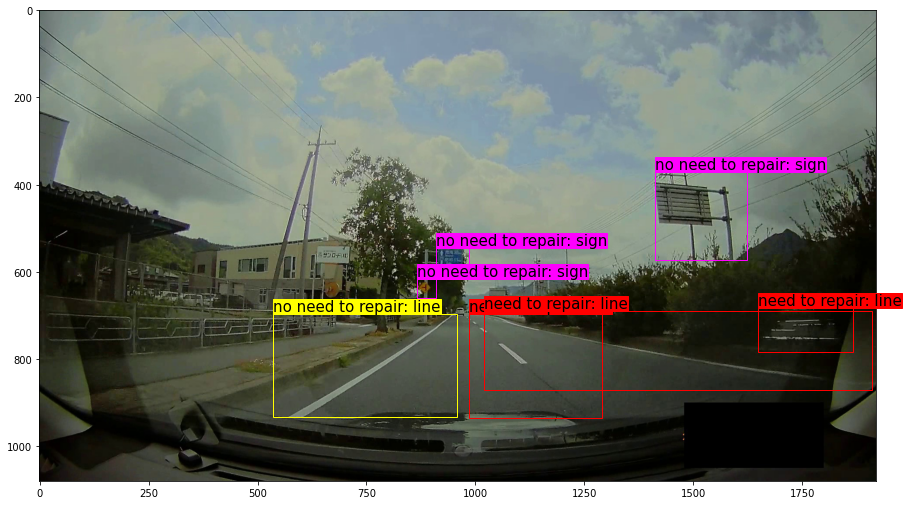

要補修-1.区画線: need to repair: line
補修不要-1.区画線: no need to repair: line
補修不要-2.道路標識: no need to repair: sign


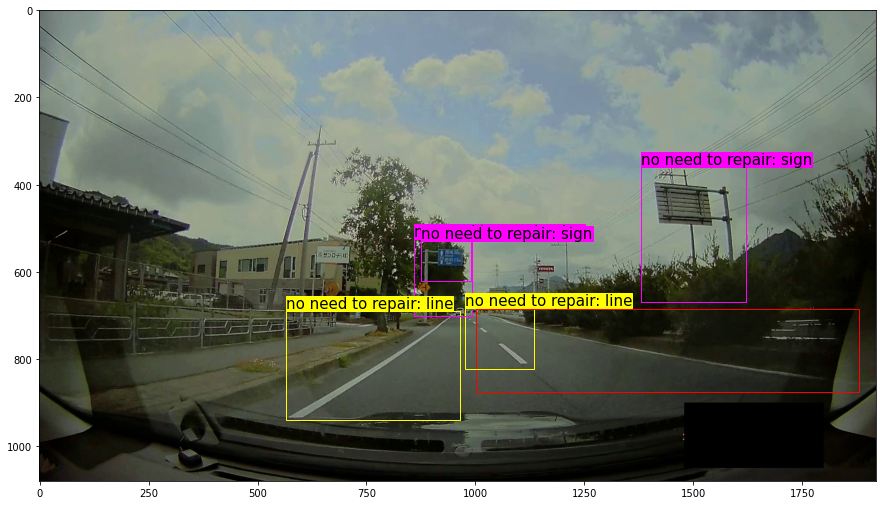

scene_10_frame_reverse_212.json
scene_08_frame_000.jpg
/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/output_frame/K-Fold/output_train/scene_08_frame_000.jpg
/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/output_frame/K-Fold/output_valid/scene_08_frame_000.jpg
補修不要-1.区画線: no need to repair: line


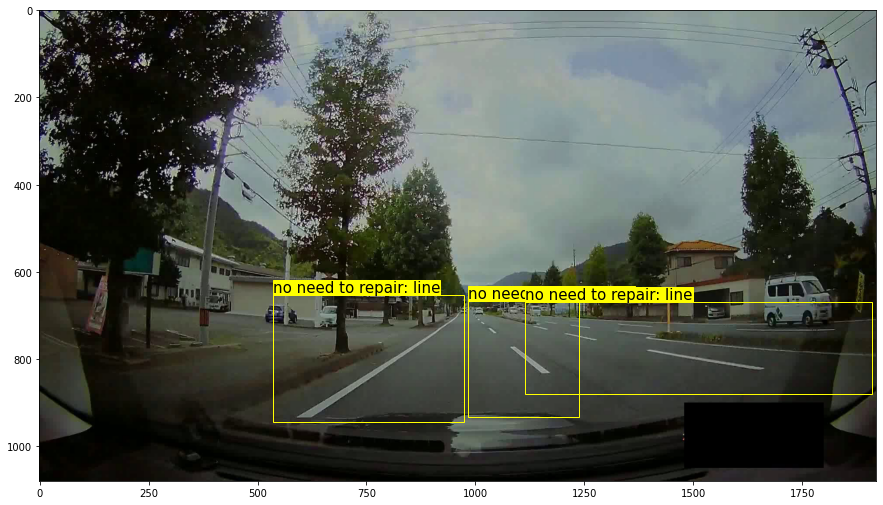

補修不要-1.区画線: no need to repair: line
要補修-1.区画線: need to repair: line


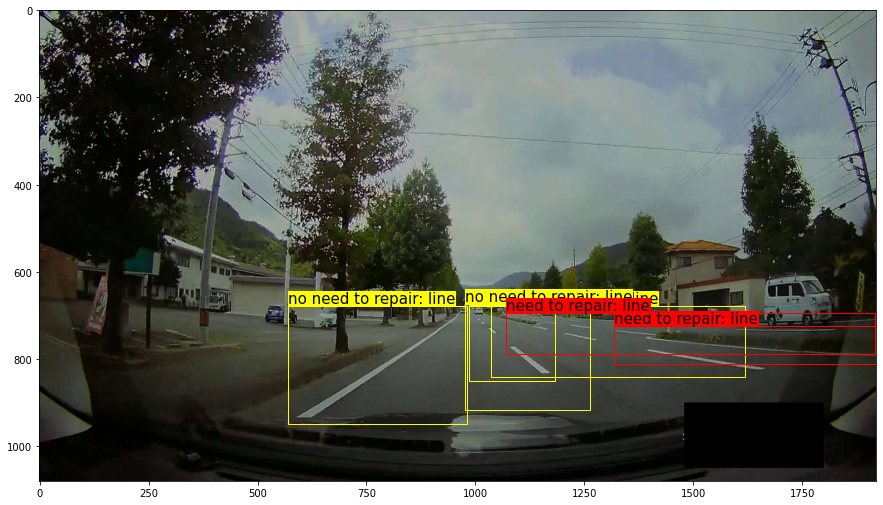

scene_16_frame_208.json
scene_10_frame_reverse_071.jpg
/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/output_frame/K-Fold/output_train/scene_10_frame_reverse_071.jpg
/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/output_frame/K-Fold/output_valid/scene_10_frame_reverse_071.jpg
補修不要-3.照明: no need to repair: light
要補修-1.区画線: need to repair: line
要補修-3.照明: need to repair: light


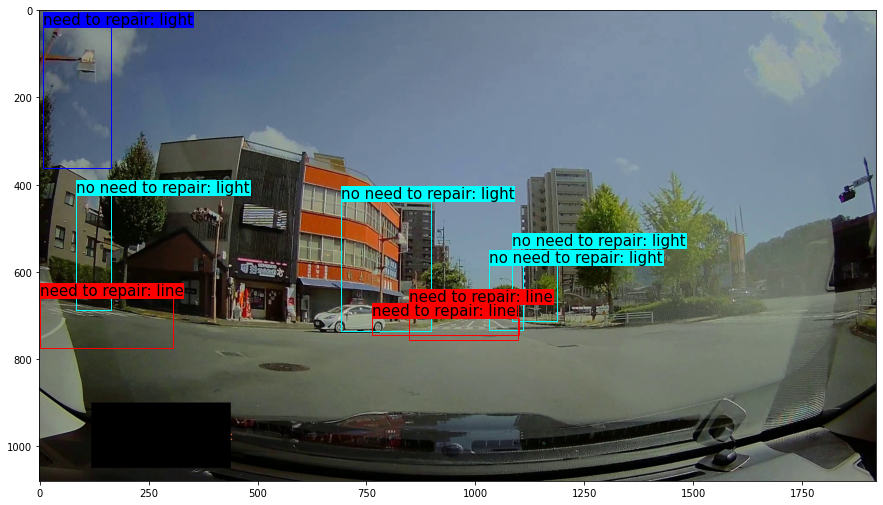

補修不要-3.照明: no need to repair: light
要補修-1.区画線: need to repair: line
要補修-3.照明: need to repair: light


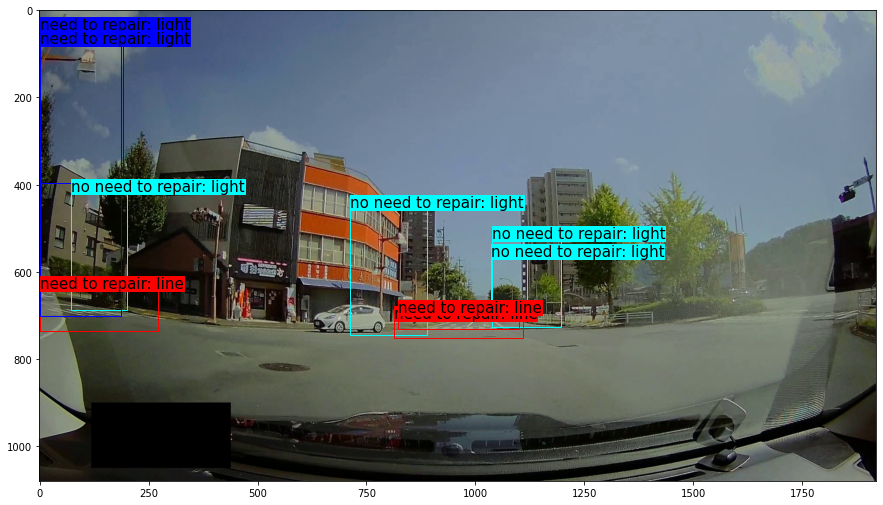

scene_02_frame_reverse_170.jpg
/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/output_frame/K-Fold/output_train/scene_02_frame_reverse_170.jpg
/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/output_frame/K-Fold/output_valid/scene_02_frame_reverse_170.jpg
補修不要-2.道路標識: no need to repair: sign
補修不要-1.区画線: no need to repair: line
要補修-1.区画線: need to repair: line


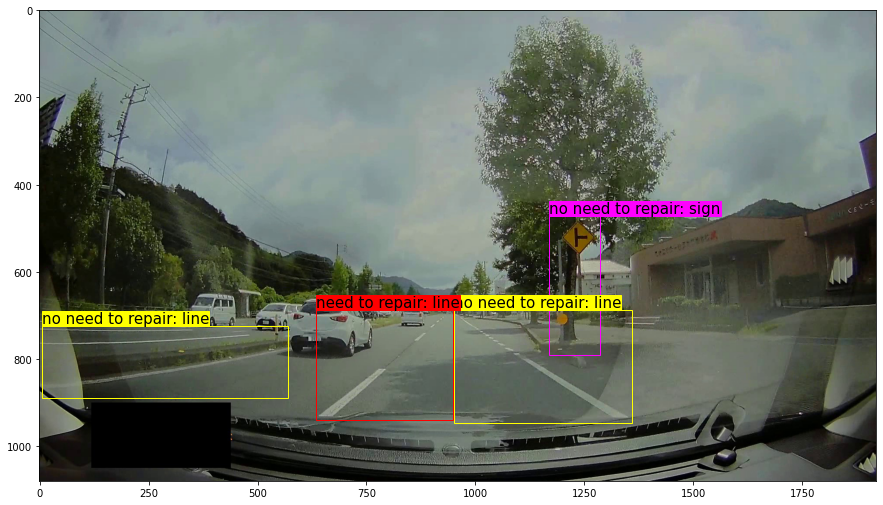

補修不要-1.区画線: no need to repair: line
要補修-1.区画線: need to repair: line
補修不要-2.道路標識: no need to repair: sign


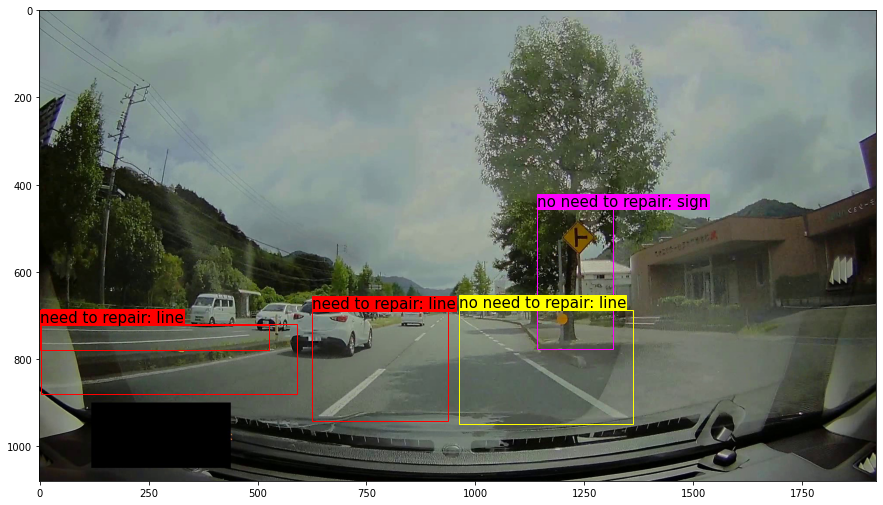

scene_10_frame_195.jpg
/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/output_frame/K-Fold/output_train/scene_10_frame_195.jpg
/content/drive/My Drive/data_analysis/competition/Signate_Yamaguchi/output_frame/K-Fold/output_valid/scene_10_frame_195.jpg
要補修-1.区画線: need to repair: line
要補修-3.照明: need to repair: light


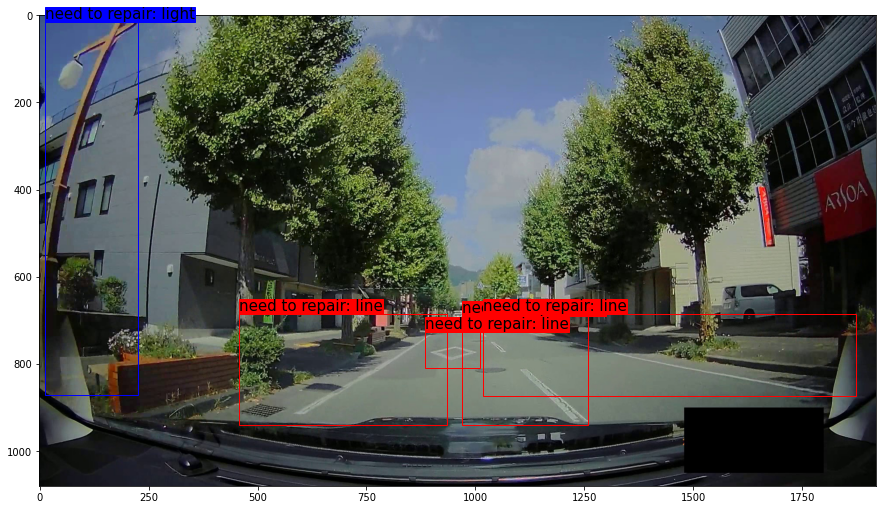

要補修-1.区画線: need to repair: line
補修不要-2.道路標識: no need to repair: sign
補修不要-3.照明: no need to repair: light


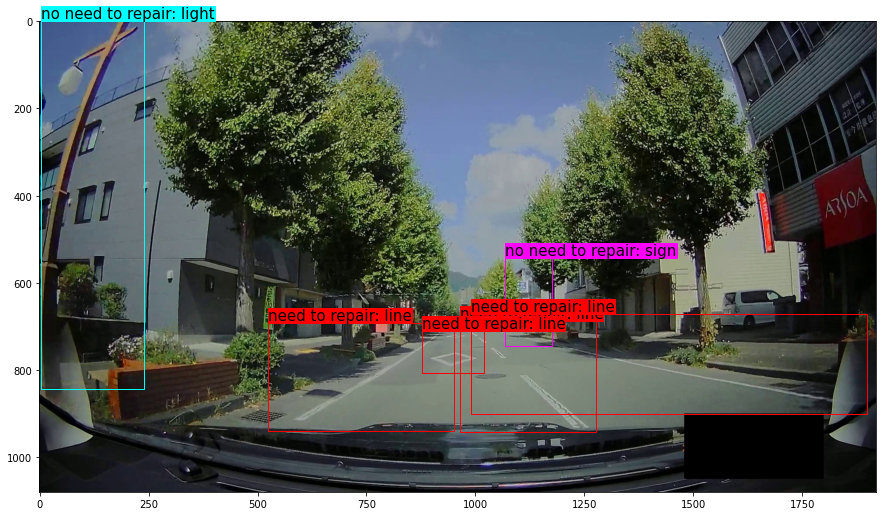

In [ ]:
for i in range(5):

  test_data = random_pick(config["valid_dir"])
  test_image = test_data[0]
  test_annotate = test_data[1]
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


  img, _ = get_transform(False)(Image.fromarray(test_image), None)
  model.eval()
  with torch.no_grad():
      prediction = model([img.to(device)])

  pred_cpu = {k: v.to('cpu').detach().numpy() for k, v in prediction[0].items()}
  pred = {k: v[np.where(pred_cpu['scores']>=0.5)] for k, v in pred_cpu.items()}

  texts_pred = []
  texts_pred.append 

  label_list = ['要補修-1.区画線', '要補修-2.道路標識', '要補修-3.照明', '補修不要-1.区画線', '補修不要-2.道路標識', '補修不要-3.照明']
  ann_pred = {'labels':{}}
  for i, label in enumerate(pred['labels']):
      if label_list[label-1] not in ann_pred['labels']:
          ann_pred['labels'][label_list[label-1]] = []
      bboxes = pred['boxes'][i]
      ann_pred['labels'][label_list[label-1]].append([[float(bboxes[0]), float(bboxes[1])],[float(bboxes[2]), float(bboxes[3])]])

  vis_annotation(test_image, test_annotate, colors, texts)
  vis_annotation(test_image, ann_pred, colors, texts)

補修不要-2.道路標識: no need to repair: sign
補修不要-3.照明: no need to repair: light
要補修-1.区画線: need to repair: line


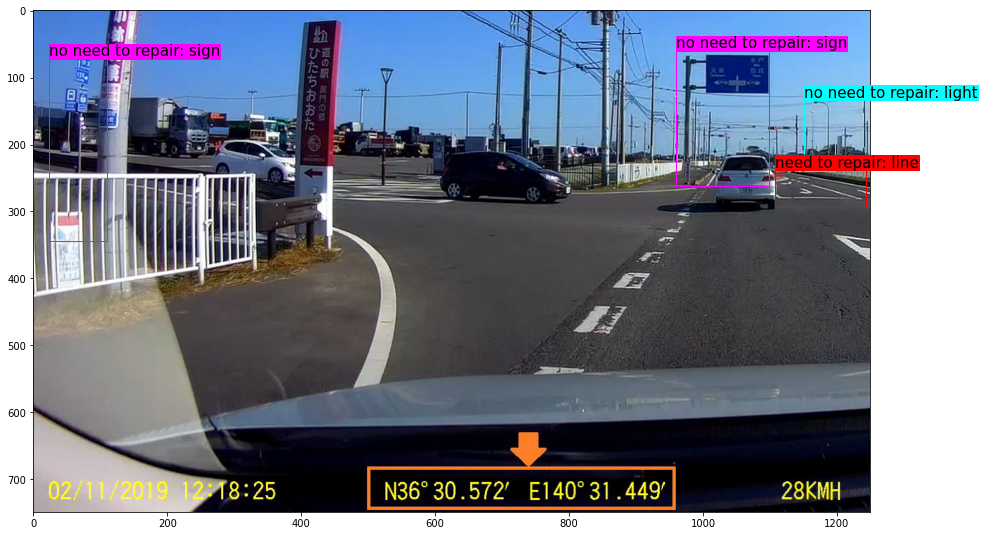

In [ ]:
  test_image = np.array(Image.open("/content/drive/MyDrive/data_analysis/competition/Signate_Yamaguchi/test_jpg/road7.jpg"))

  img, _ = get_transform(False)(Image.fromarray(test_image), None)
  model.eval()
  with torch.no_grad():
      prediction = model([img.to(device)])

  pred_cpu = {k: v.to('cpu').detach().numpy() for k, v in prediction[0].items()}
  pred = {k: v[np.where(pred_cpu['scores']>=0.5)] for k, v in pred_cpu.items()}

  label_list = ['要補修-1.区画線', '要補修-2.道路標識', '要補修-3.照明', '補修不要-1.区画線', '補修不要-2.道路標識', '補修不要-3.照明']
  ann_pred = {'labels':{}}
  for i, label in enumerate(pred['labels']):
      if label_list[label-1] not in ann_pred['labels']:
          ann_pred['labels'][label_list[label-1]] = []
      bboxes = pred['boxes'][i]
      ann_pred['labels'][label_list[label-1]].append([[float(bboxes[0]), float(bboxes[1])],[float(bboxes[2]), float(bboxes[3])]])
  vis_annotation(test_image, ann_pred, colors, texts)